# Plots

v.1 Jiayao Zhang
June 22

In [ ]:
from __future__ import print_function, absolute_import, division
%load_ext autoreload
%autoreload 2
from pathlib import Path
import numpy as np
import pandas as pd
import tqdm
import json
import uuid
import sqlite3
import itertools

In [392]:
import seaborn as sns
import matplotlib
from matplotlib import pyplot as plt

sns.set()
sns.set(font_scale=2.5,)
sns.set_style("white")
sns.set_palette("colorblind")


plt.rcParams.update({'font.size': 20, 'lines.linewidth':4, 'lines.markersize':12, 
    'xtick.labelsize':15, 'ytick.labelsize':15, 'axes.labelsize':20,
    'axes.titlesize': 20, 'legend.fontsize':20,
    'pdf.fonttype': 42, 'ps.fonttype':42, 
    'image.interpolation':'nearest', 'figure.figsize': (10,8),
    "text.usetex": True,
         'text.latex.preamble': r"""
        \usepackage{libertine}
        \usepackage[libertine]{newtxmath}
        """,
})
tqdm.tqdm.pandas()

import logging
logging.getLogger().setLevel(logging.CRITICAL)
import warnings
warnings.filterwarnings("ignore", )

# Load Results

In [33]:
Ns = ['c365','c730','c1095']

In [418]:
full_smps = pd.read_csv('./data/bootstrap/nongrp_bootstrap_smps.csv')
subgrp_smps = pd.read_csv('./data/bootstrap/stratified_bootstrap_smps.csv')

In [419]:
def sort_df(df,Ns,col='t'):
    """Sort result dataframe."""
    df['N_numeric'] = df['N'].apply(lambda s:int(s[1:]))
    return df.sort_values(['N_numeric',col],
                      ascending=[True,True],)

def get_ci_table(boot_df, effect_col='DiD', groups=['N','t'], alpha=0.05):
    ll = alpha / 2.
    hl = 1. - ll
    return pd.concat([
      boot_df.groupby(groups)[effect_col].apply(lambda s : np.mean(s)).to_frame('r'),
      boot_df.groupby(groups)[effect_col].apply(lambda s : np.quantile(s,ll)).to_frame('ll'),
     boot_df.groupby(groups)[effect_col].apply(lambda s : np.quantile(s,hl)).to_frame('hl'),
    ],axis=1)
    

In [ ]:
full_smps = sort_df(full_smps.reset_index(), Ns, 't')
subgrp_smps = sort_df(subgrp_smps.reset_index(), Ns, 't')

In [420]:
subgrp_smps.loc[(subgrp_smps.grp=='Max Author Citation')&
                (subgrp_smps.level=='others'),
                'level'] = 'Other Authors'
subgrp_smps.loc[(subgrp_smps.grp=='Min Institution Rank')&
                (subgrp_smps.level=='others'),
                'level'] = 'Other Institutions'

In [421]:
full_smps_ci = get_ci_table(full_smps, groups=['N','t','q','t_lb'])
subgrp_smps_ci = get_ci_table(subgrp_smps, 
                              groups=['grp','level','N','t','q','t_lb'])

In [422]:
full_smps_ci = sort_df(full_smps_ci.reset_index(), Ns, 't')
subgrp_smps_ci = sort_df(subgrp_smps_ci.reset_index(), Ns, 't')

# Plots

## Fig. 2 Non-Subgroup Vertical

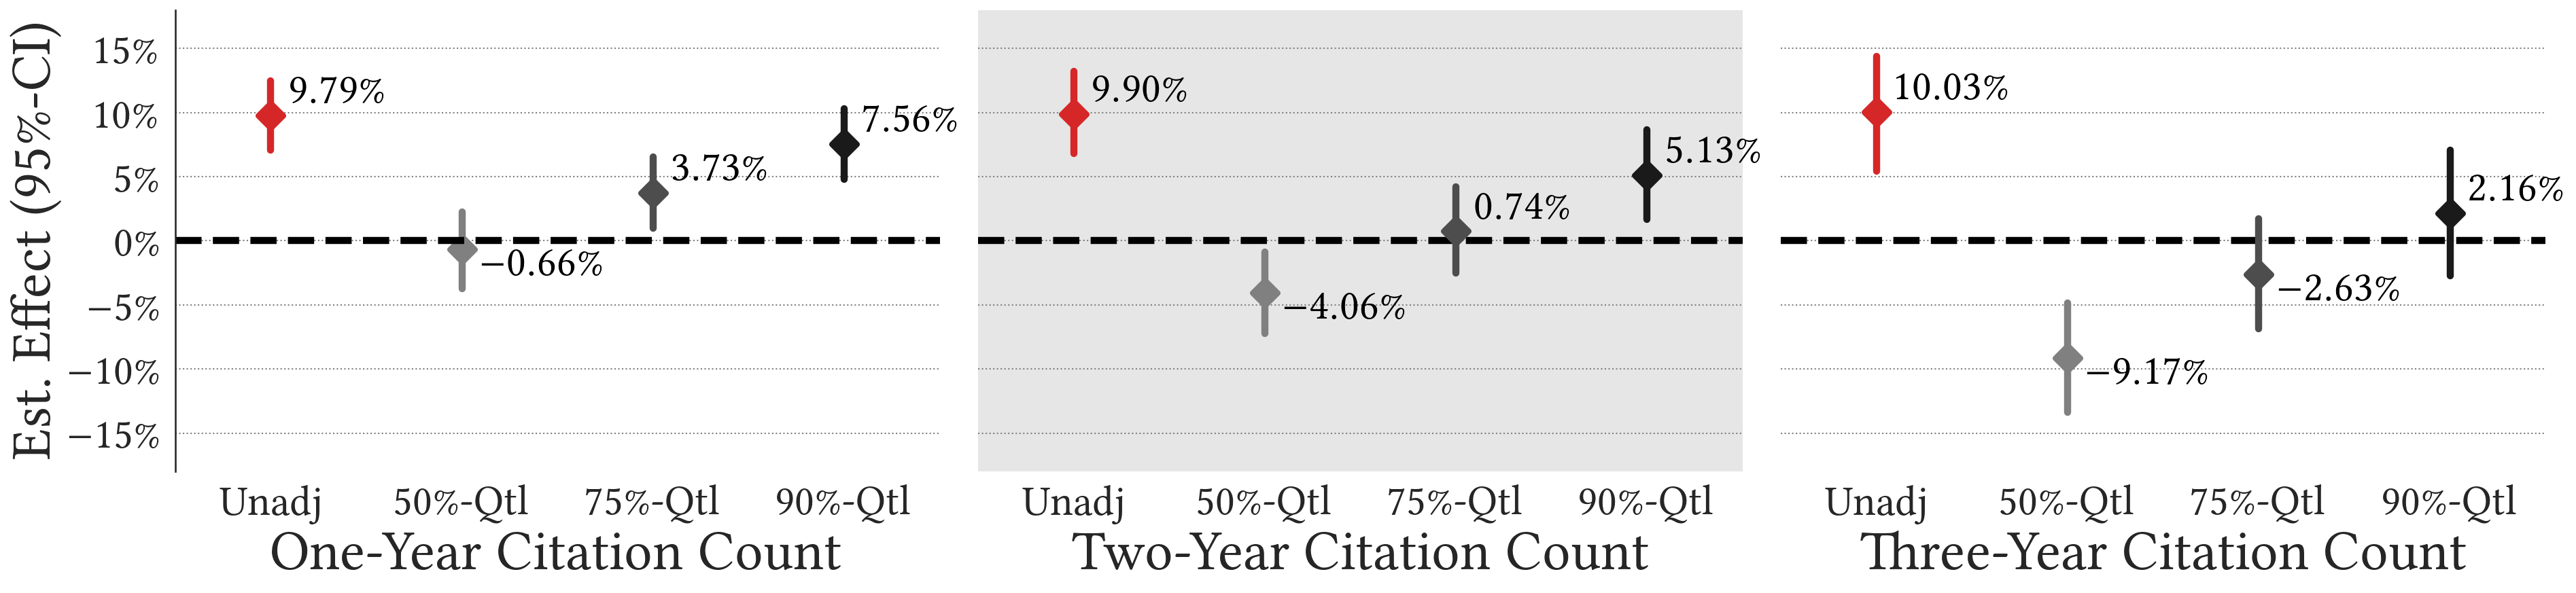

In [607]:
fig, axes = plt.subplots(ncols=3, figsize=(30, 6), dpi=150)
plt.subplots_adjust(hspace=0,wspace=0.05)
bg_facecolors = ['1','0.9','1']
palette = {'0\%':'tab:red', '50\%':'0.5', '75\%':'0.3', '90\%':'0.1', }
quantiles = ['Unadj',r'$50\%$-Qtl',r'$75\%$-Qtl', r'$90\%$-Qtl']

for i, (N, ax) in enumerate(zip(Ns, axes)):
    
    g = sns.pointplot(
        data=full_smps[full_smps.N==N],
        y="DiD", x="t_lb", hue='q', 
        orient='v',
        markers='D',
        scale=0.7,
        errorbar=("pi", 95), capsize=0, join=False, 
        palette=palette,
        ax=ax
    )
    
    # cosmetic changes
    [ax.spines[k].set_visible(False) for k in ['top','bottom','right']]
    if i != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticklabels([])
    if i == 0:
        ax.set_ylabel(r'Est.~Effect ($95\%$-CI)', fontsize=40)
        ax.set_yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
        ax.set_yticklabels([rf"${a}\%$" for a in np.arange(-15,16,5)])
    else:
        ax.set_ylabel('')
        ax.set_yticks([-0.15,-0.1,-0.05,0,0.05,0.1,0.15])
    ax.set_facecolor(bg_facecolors[i])
    ax.set_xlabel(['One','Two','Three'][i]+'-Year Citation Count',fontsize=40)
    ax.axhline(0, ls='--', c='0', lw=2, )
    ax.grid(True, color='grey', which='major', axis='y', lw=1, ls=':')
    
    # add data label
    point_est = full_smps_ci.query(f"N=='{N}'").r.values
    [ax.text(p+0.1, l-0.02 if l < 0 else l+0.01, r"$"+f"{100*l:.2f}\%"+r"$", 
             color='0', fontsize=30) 
         for p,l in zip(ax.get_xticks(), point_est)]

    
    ax.get_legend().remove()
    ax.set_ylim(-0.18,0.18)
    g.set_xticklabels(quantiles)
    plt.setp(g.lines,linewidth=5)
    plt.setp(g.lines,linewidth=5)
    ax.tick_params(axis='x', which='major', labelsize=30)
    ax.tick_params(axis='y', which='major', labelsize=30)
plt.savefig('fullsmp_ci_tnr.pdf',bbox_inches='tight')



## Horizontal Subgrp (Inst)

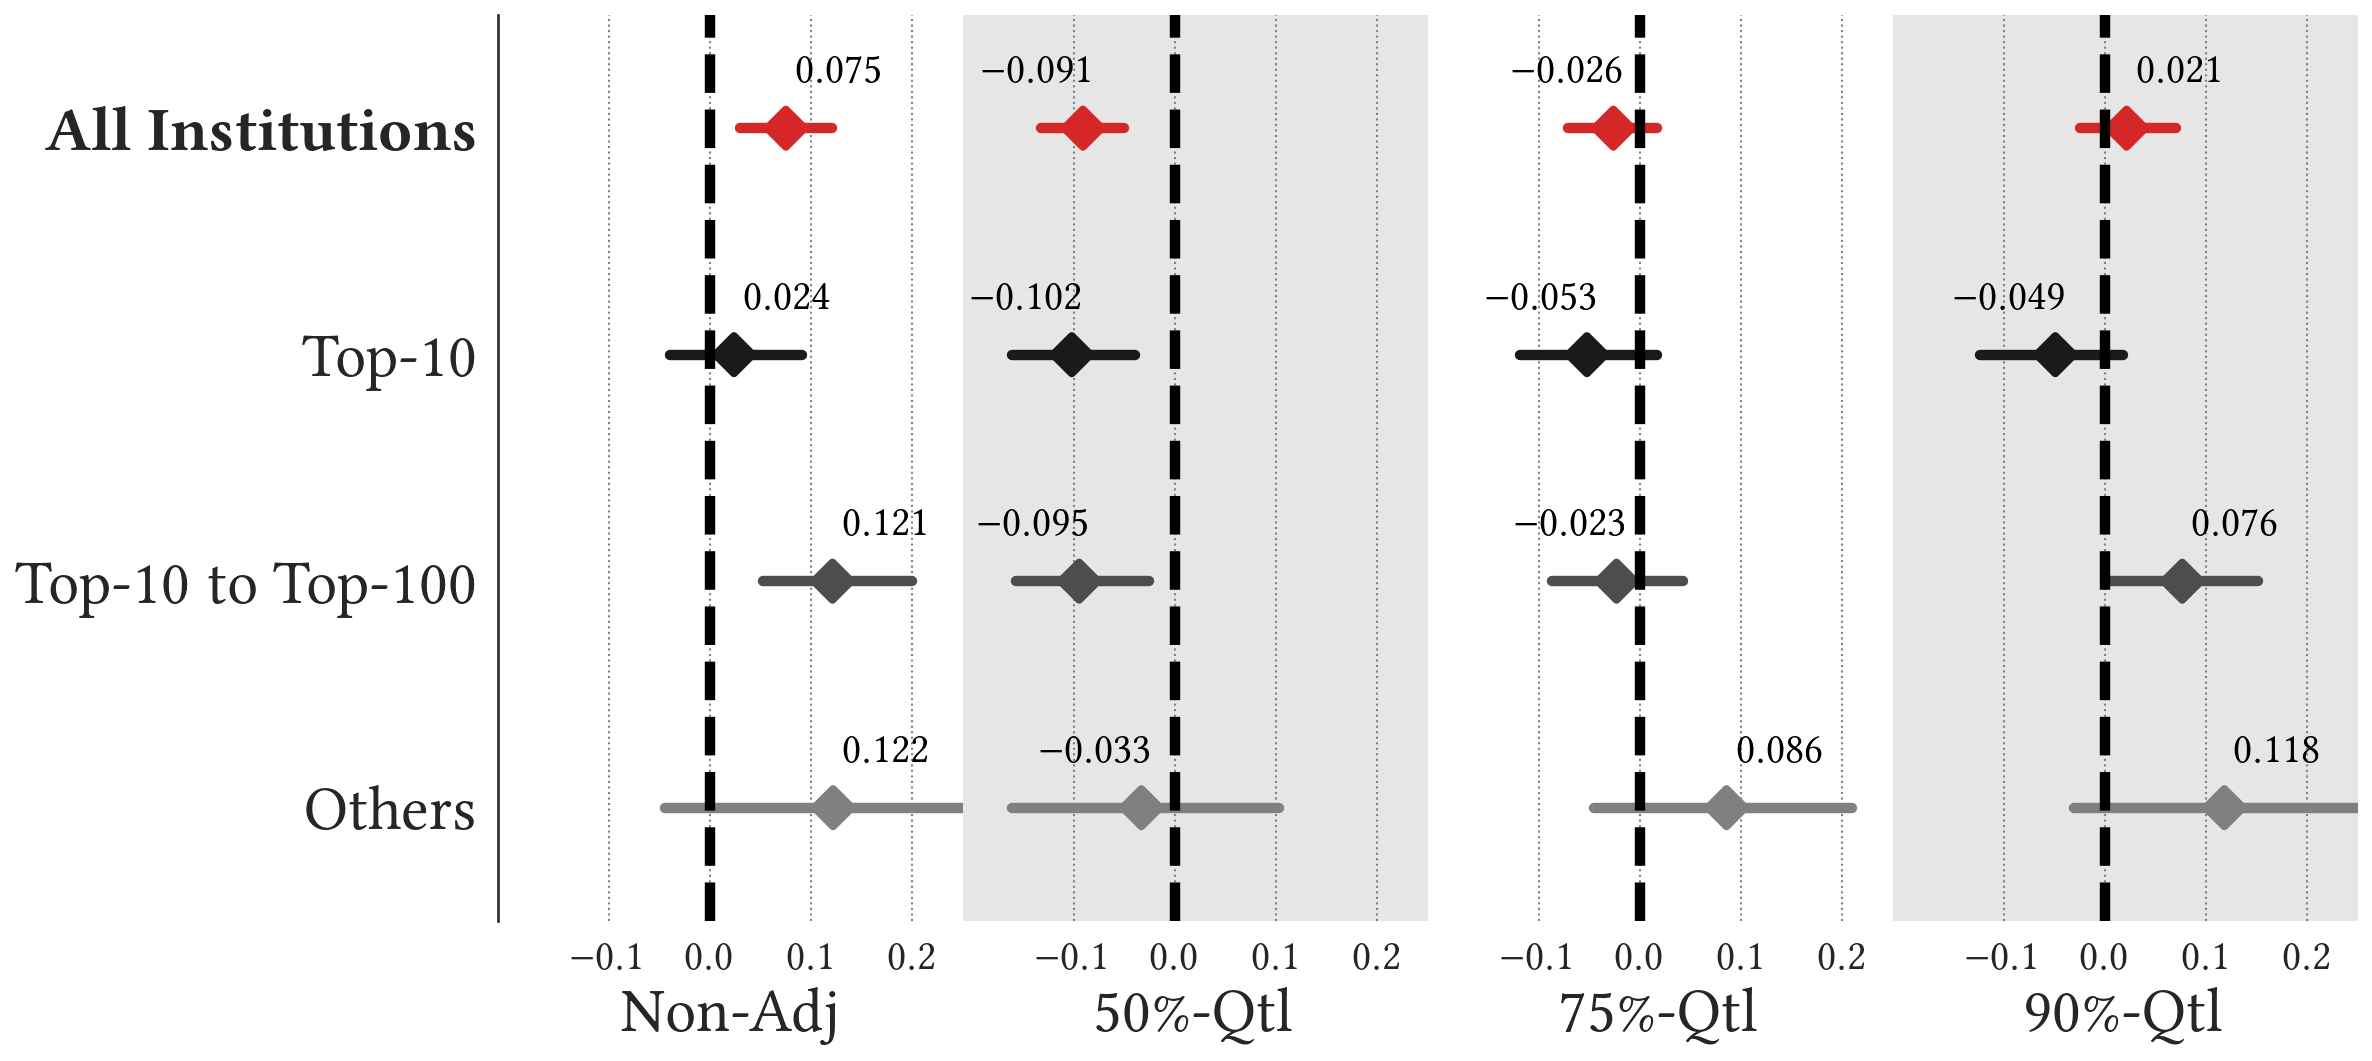

In [426]:
fig, axes = plt.subplots(ncols=4, figsize=(16, 8), dpi=150)
plt.subplots_adjust(hspace=0,wspace=0)
bg_facecolors = ['1','0.9','1','0.9']

palette = {
    'All Institutions':'tab:red', 
        'top-10': '0.1', 
        '10-100': '0.3', 
        'Other Institutions': '0.5',
       'All Authors': 'tab:red', 
        '<100': '0.1', 
        '100-10000': '0.3', 
        '>10000': '0.5'
}

subgrp_lbs = [r'\textbf{All Institutions}', 'Top-10', 'Top-10 to Top-100', 'Others']
qs = ['0\%','50\%','75\%','90\%']
quantiles = [r'Non-Adj',r'$50\%$-Qtl',r'$75\%$-Qtl', r'$90\%$-Qtl']
grp = 'Min Institution Rank'#, 'Max Author Citation''
lvs = subgrp_smps['level'].unique()
lvs = ['All Institutions', 'top-10', '10-100', 'Other Institutions']
n_lv = len(lvs) 
N = Ns[-1]

for i, (q, ax) in enumerate(zip(qs, axes)):

    plt_dt = subgrp_smps.query(f"N=='{N}' and q=='{q}' and grp=='{grp}'")
    g = sns.pointplot(
        data=plt_dt,
        x="DiD", y="level", 
        orient='h',
        markers='D',
        scale=0.7,
        errorbar=("pi", 95), capsize=0, join=False, 
        palette=palette,
        ax=ax
    )
    
    # cosmetic changes
    ax.axvline(0, ls='--', c='0', lw=2, )
    ax.grid(True, color='grey', which='major', axis='x', lw=1, ls=':')
    [ax.spines[k].set_visible(False) for k in ['top','bottom','right']]
    if i != 0:
        ax.spines['left'].set_visible(False)
        ax.set_yticklabels([])
    if i == 0:
        ax.set_yticklabels(subgrp_lbs)
        ax.set_ylabel(r'', fontsize=30)
    else:
        ax.set_ylabel('')
    ax.set_facecolor(bg_facecolors[i])
    ax.set_xlabel(quantiles[i], fontsize=30)
        
    # add data label
    point_est = subgrp_smps_ci.query(
            f"N=='{N}' and q=='{q}' and grp=='{grp}'"
    ).set_index('level').loc[lvs].r.values
    [ax.text(l-0.1 if l<0 else l+0.01, p-0.2, r"$"+f"{l:.3f}"+r"$", color='0') 
         for p,l in zip(ax.get_yticks(), point_est)]

    ax.set_xlim(-0.21,0.25)
    ax.set_xticks([-0.1,0,0.1,0.2])

    plt.setp(g.lines,linewidth=5)
    plt.setp(g.lines,linewidth=5)
    ax.tick_params(axis='x', which='major', labelsize=20)
    ax.tick_params(axis='y', which='major', labelsize=30)

# plt.savefig('N3_inst_ci.pdf',bbox_inches='tight')

## Vertical Subgrp (Inst)

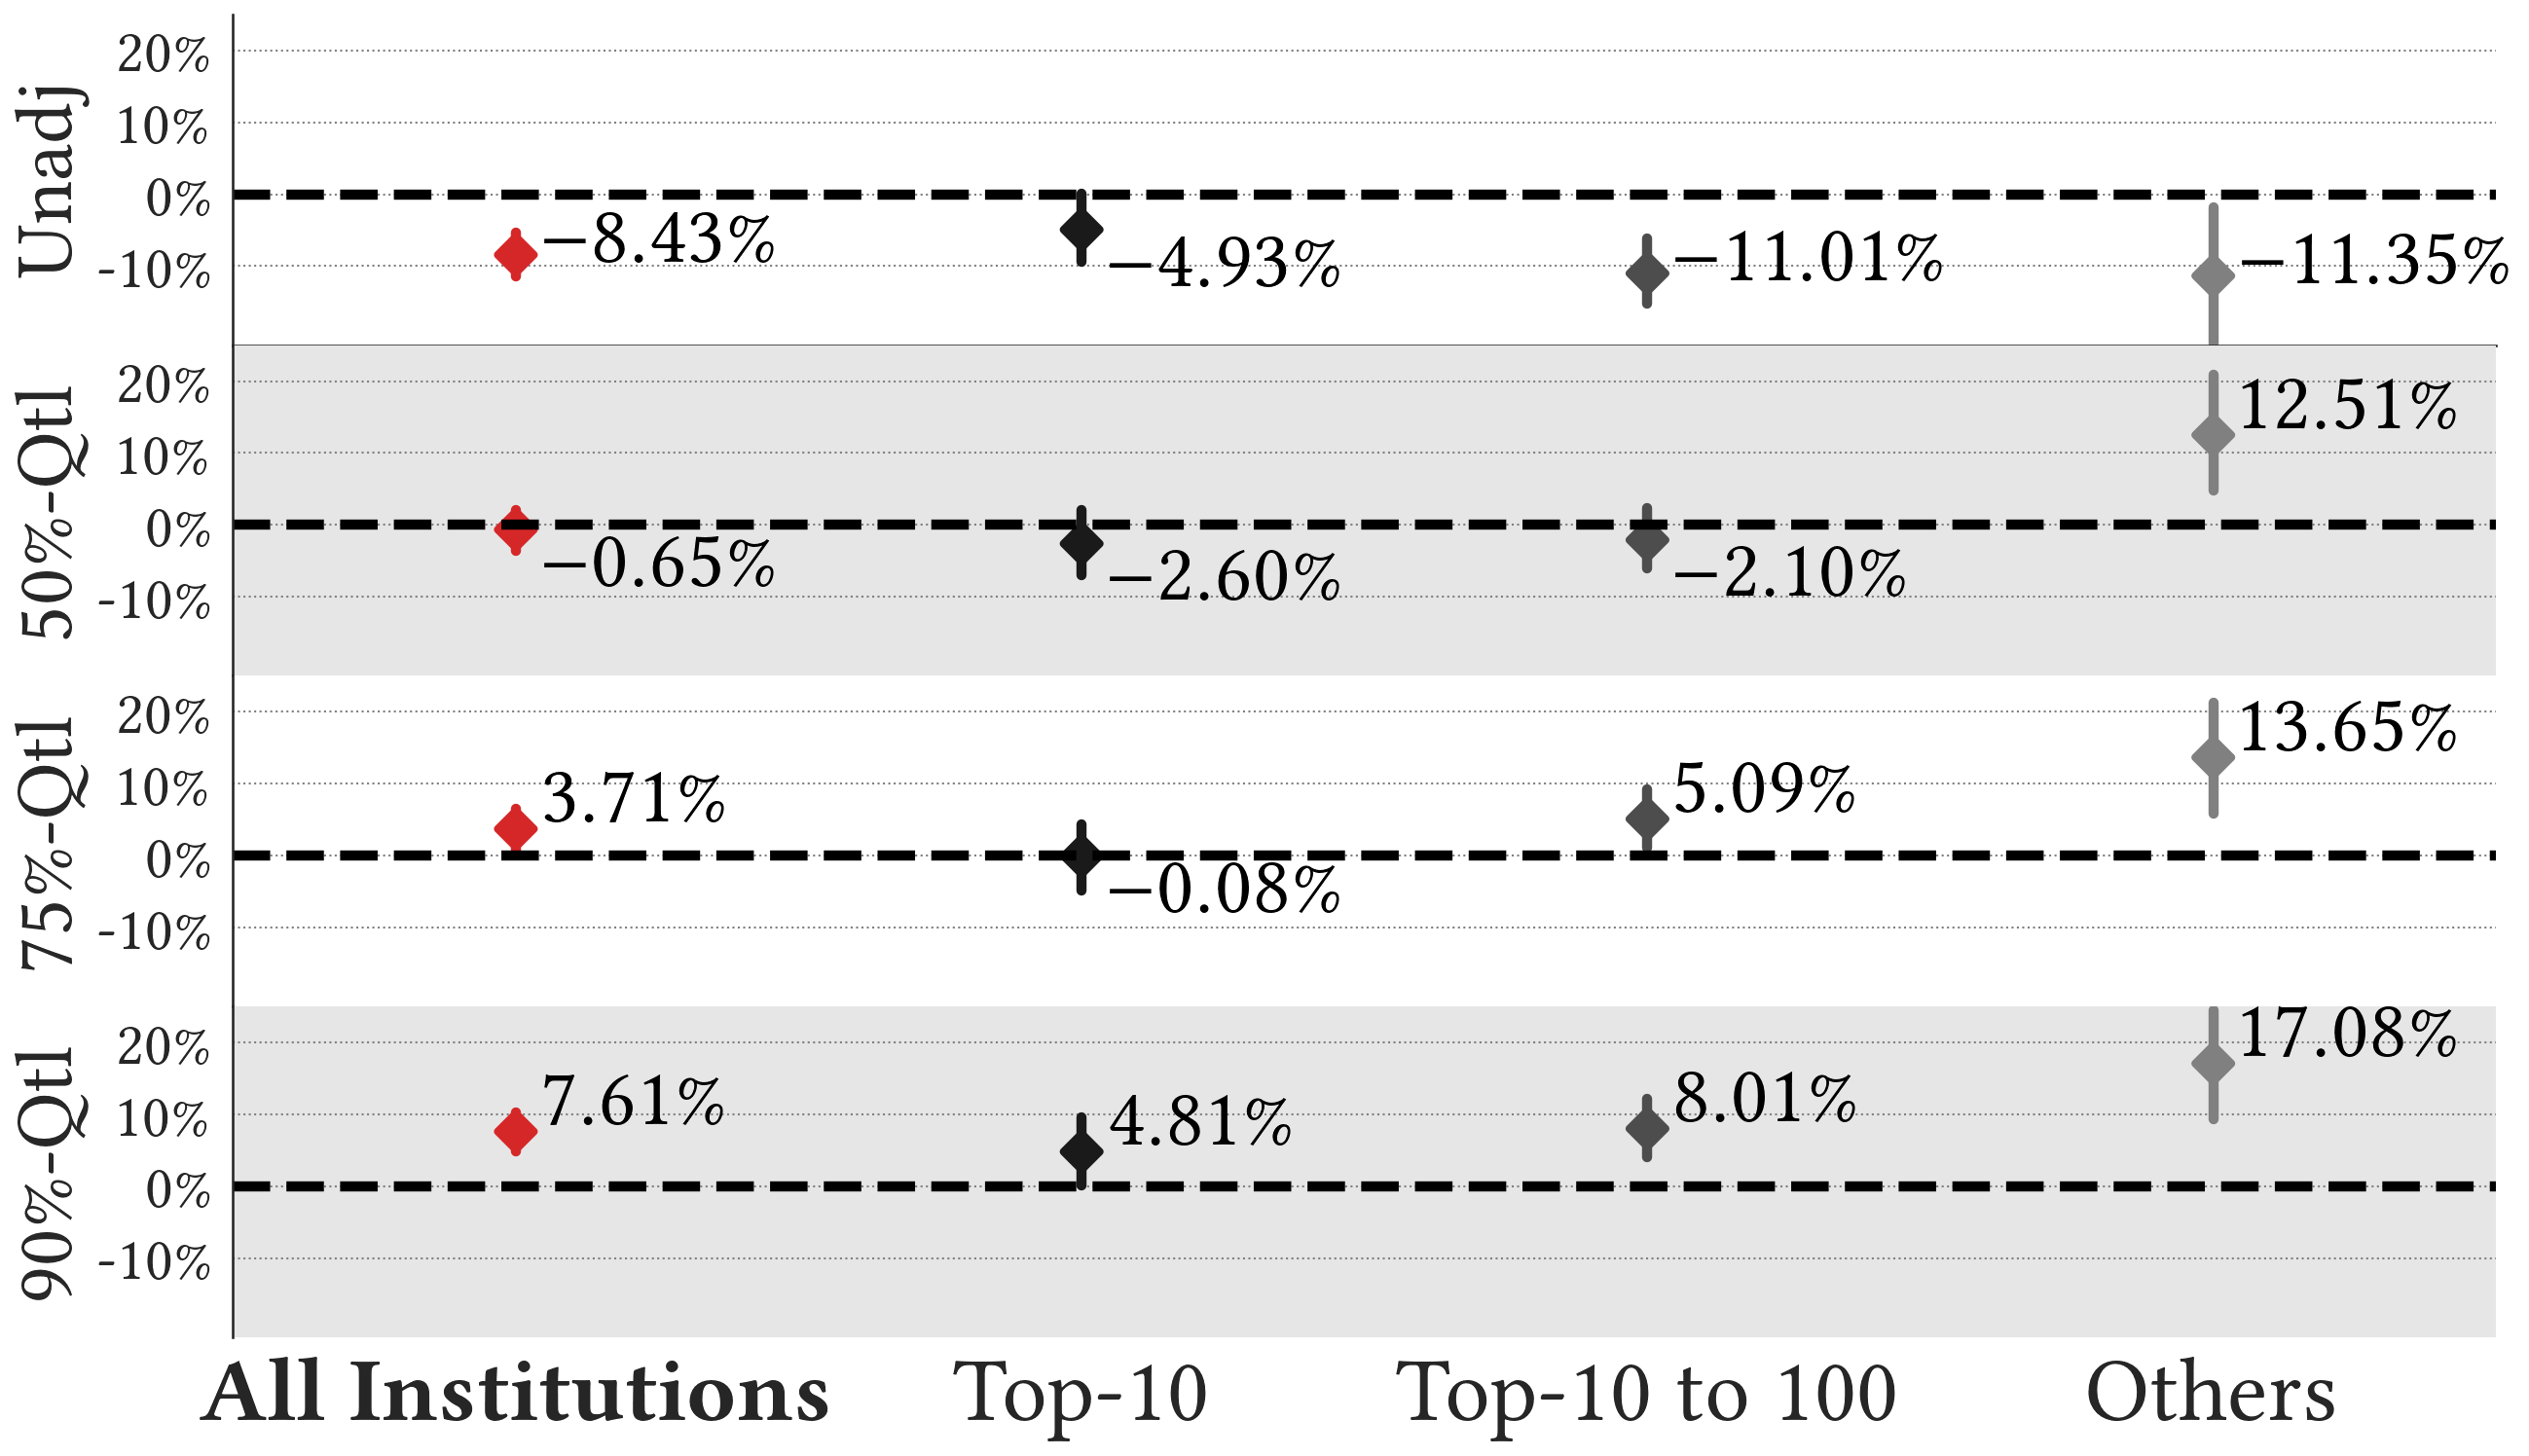

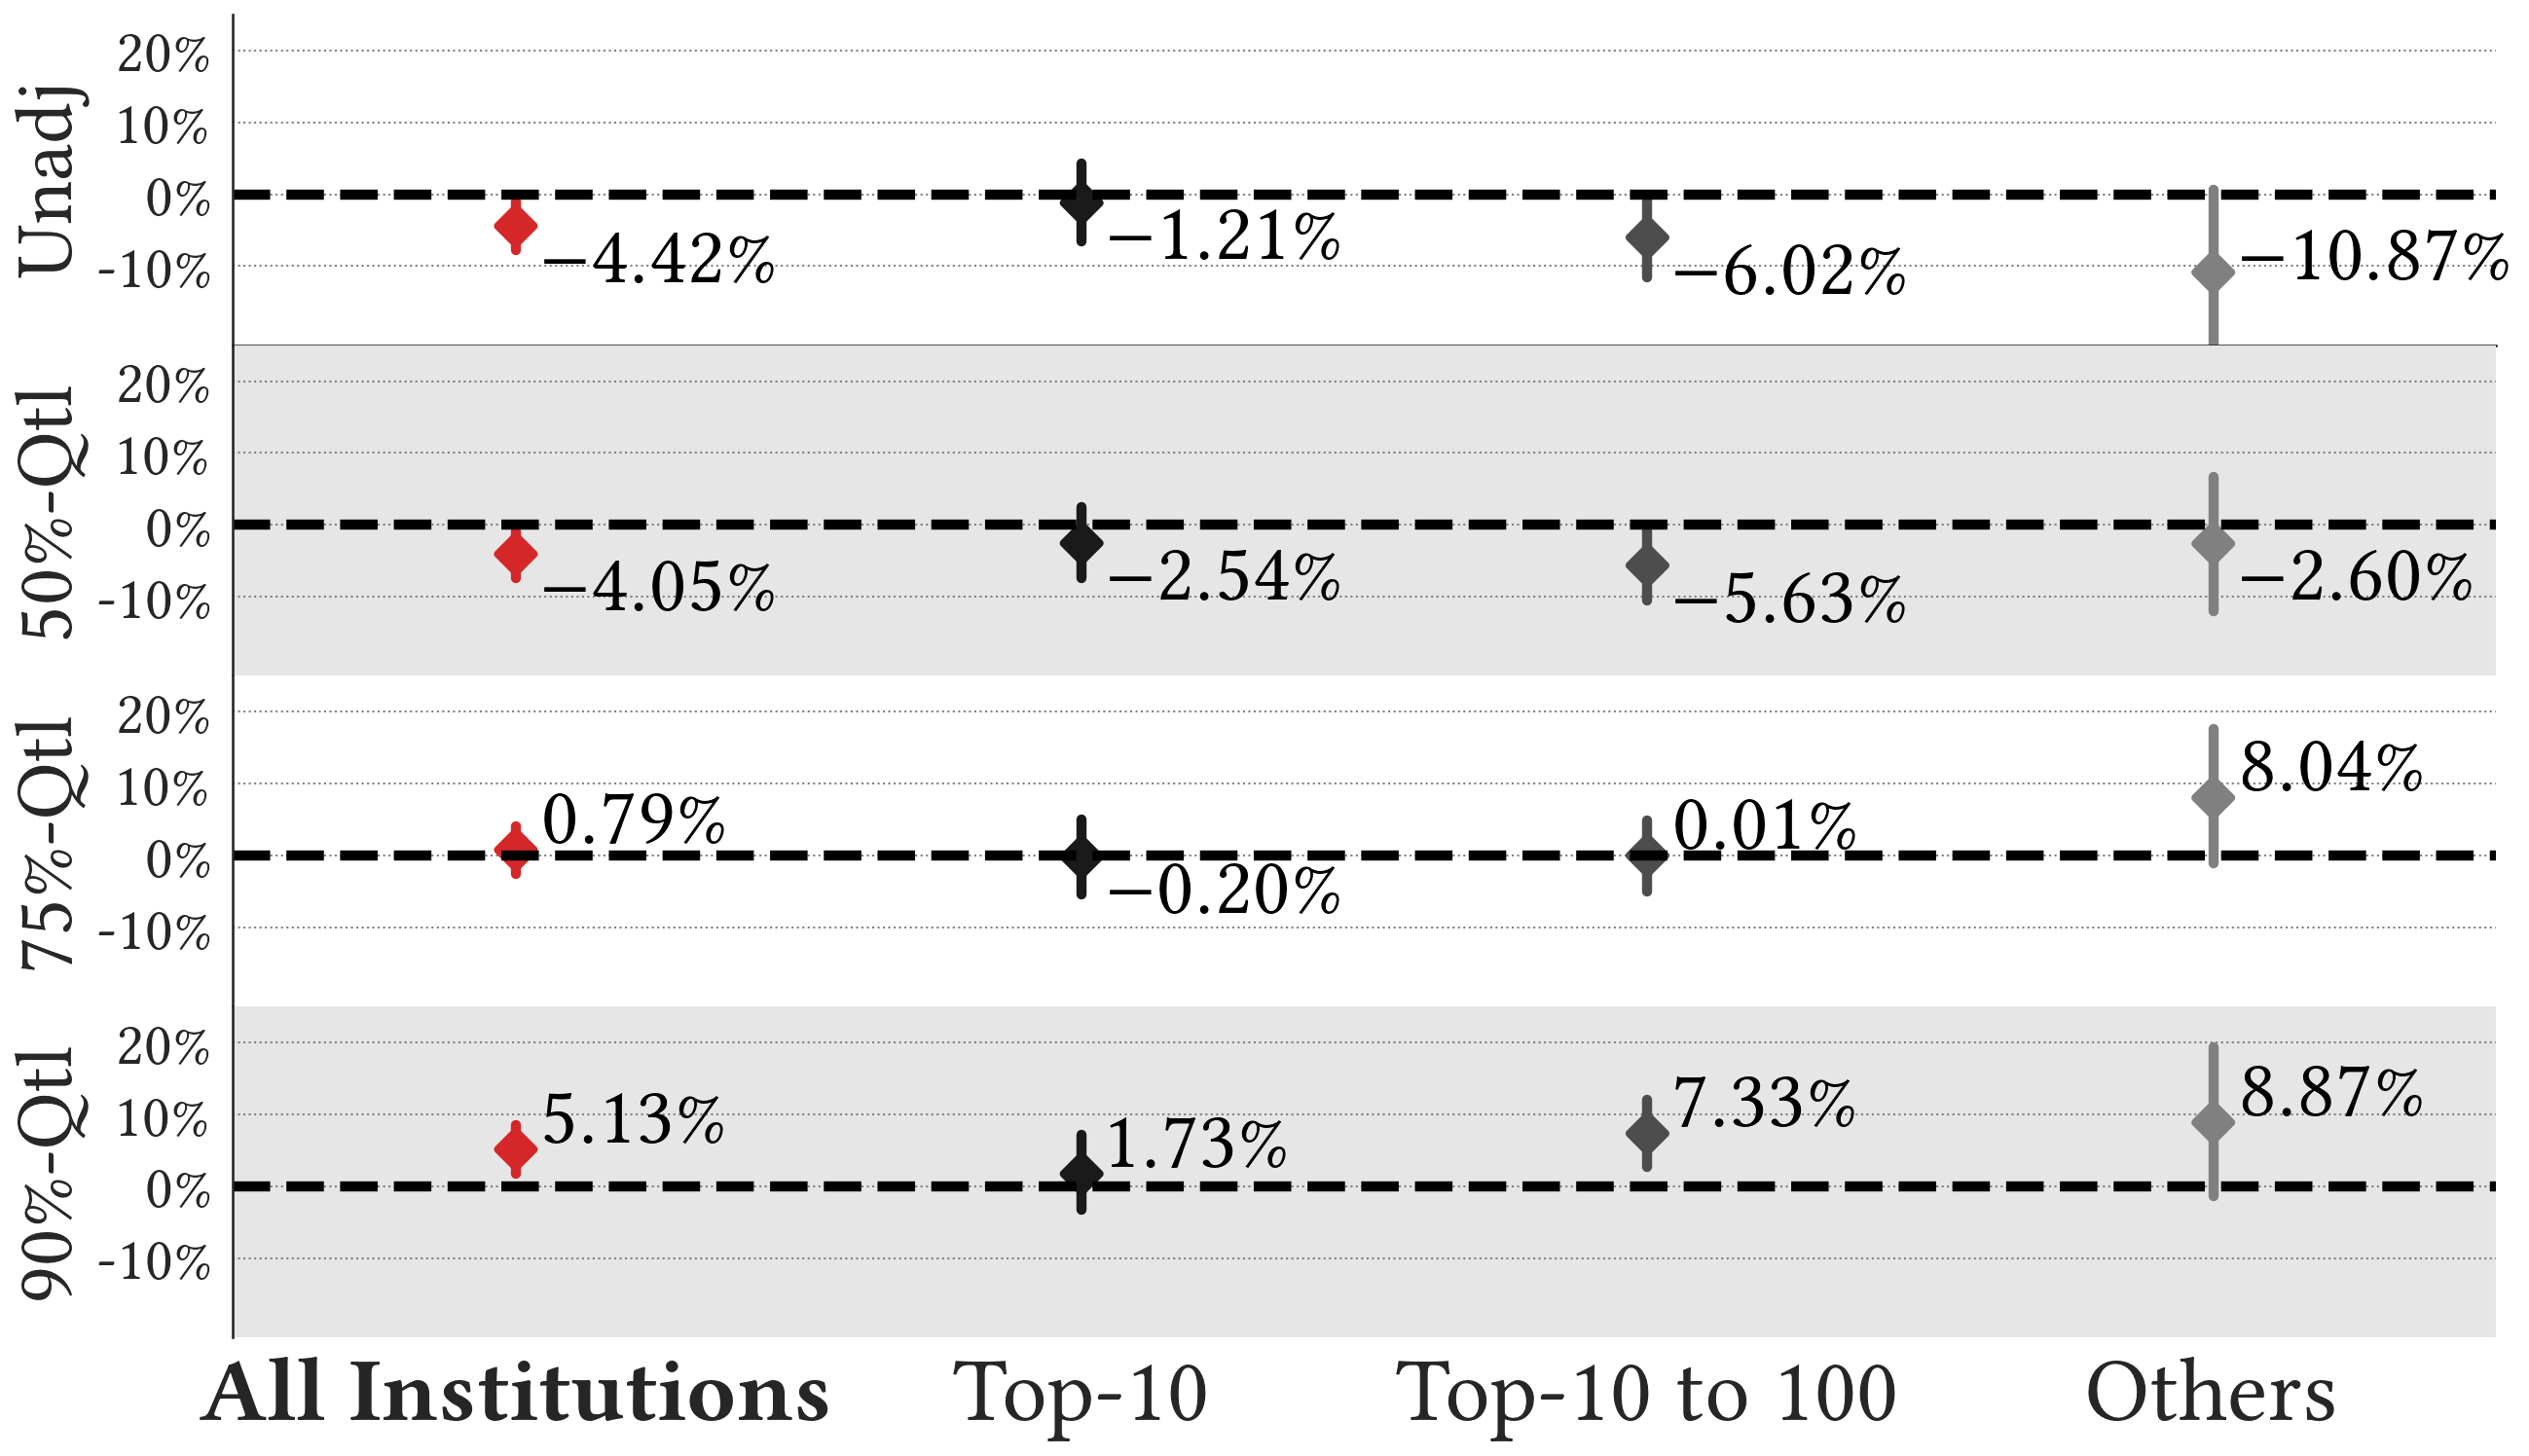

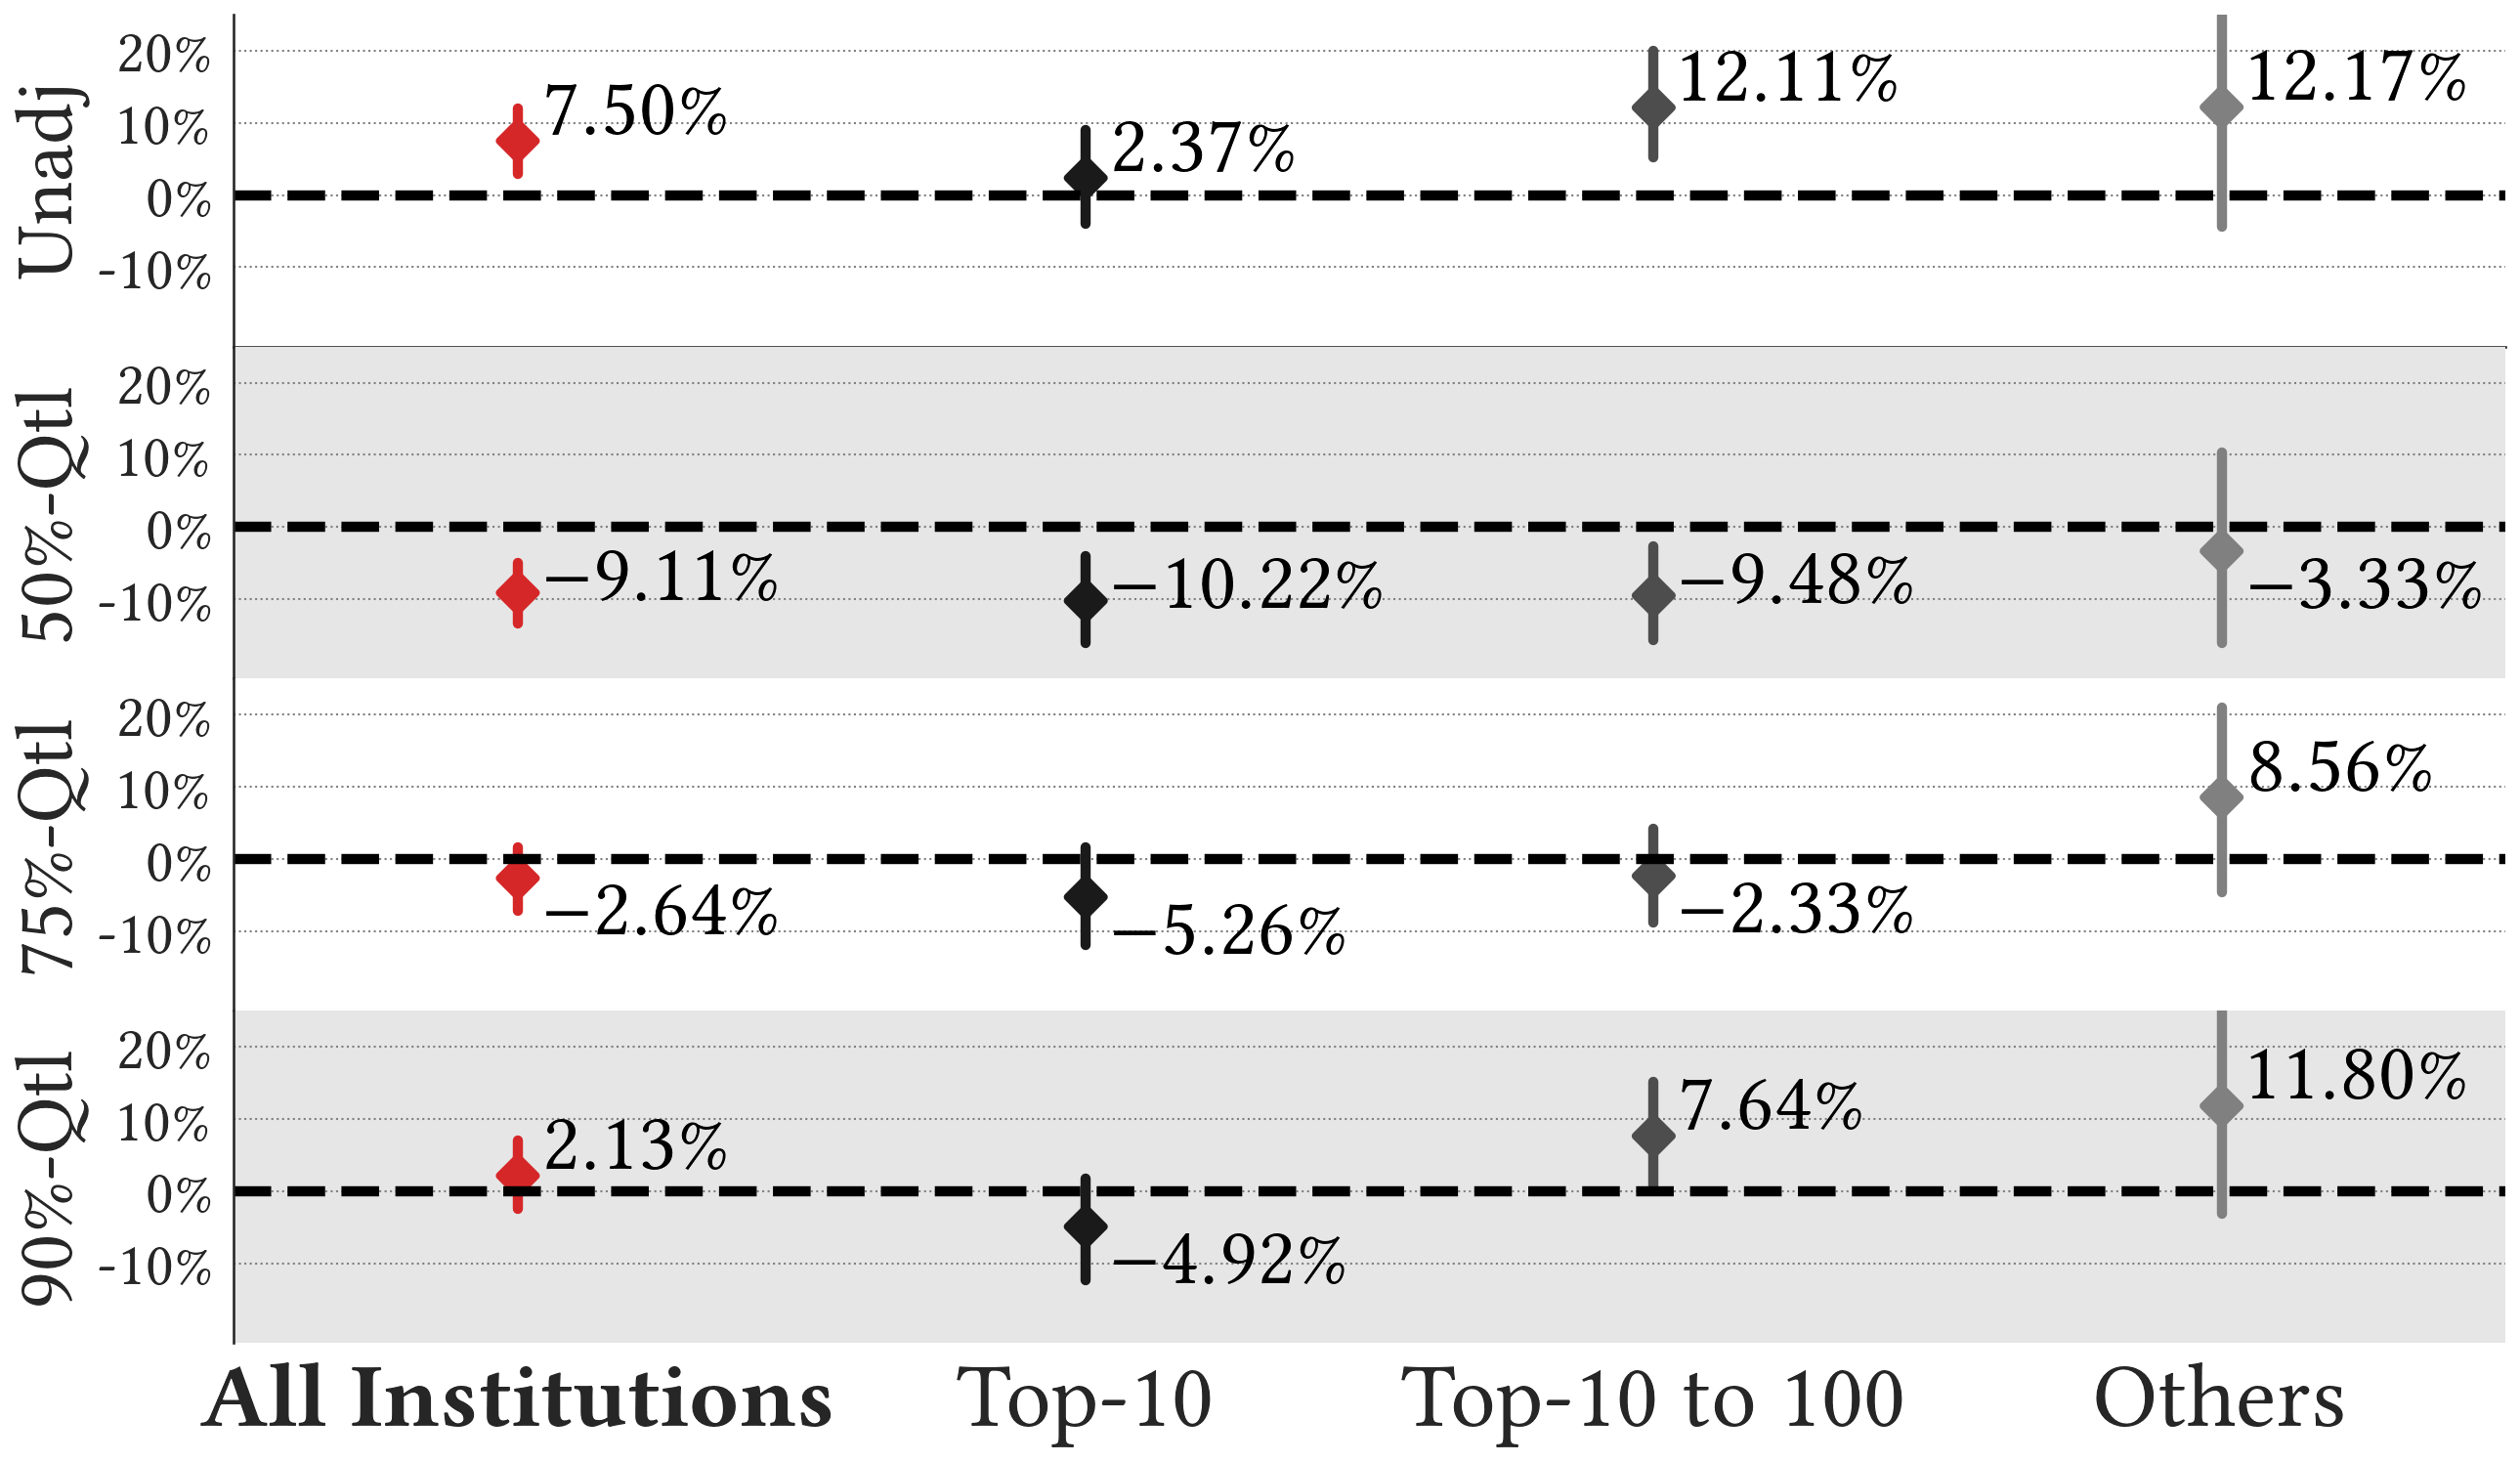

In [606]:
for idx, N in enumerate(Ns):
    fig, axes = plt.subplots(nrows=4, figsize=(20, 12), dpi=150)
    plt.subplots_adjust(hspace=0,wspace=0)
    bg_facecolors = ['1','0.9','1','0.9']

    palette = {
        'All Institutions':'tab:red', 
            'top-10': '0.1', 
            '10-100': '0.3', 
            'Other Institutions': '0.5',
           'All Authors': 'tab:red', 
            '<100': '0.1', 
            '100-10000': '0.3', 
            '>10000': '0.5'
    }

    subgrp_lbs = [r'\textbf{All Institutions}', 'Top-10', 'Top-10 to 100', 'Others']
    qs = ['0\%','50\%','75\%','90\%']
    quantiles = [r'Unadj',r'$50\%$-Qtl',r'$75\%$-Qtl', r'$90\%$-Qtl']
    grp = 'Min Institution Rank'#, 'Max Author Citation''
    lvs = subgrp_smps['level'].unique()
    lvs = ['All Institutions', 'top-10', '10-100', 'Other Institutions']
    n_lv = len(lvs) 


    for i, (q, ax) in enumerate(zip(qs, axes)):

        plt_dt = subgrp_smps.query(f"N=='{N}' and q=='{q}' and grp=='{grp}'")
        g = sns.pointplot(
            data=plt_dt,
            y="DiD", x="level", 
            orient='v',
            markers='D',
            scale=0.7,
            errorbar=("pi", 95), capsize=0, join=False, 
            palette=palette,
            ax=ax
        )

        # cosmetic changes
        ax.axhline(0, ls='--', c='0', lw=2, )
        ax.grid(True, color='grey', which='major', axis='y', lw=1, ls=':')
        [ax.spines[k].set_visible(False) for k in ['top','right']]
        if i != 0:
            ax.spines['bottom'].set_visible(False)
        ax.set_facecolor(bg_facecolors[i])
        ax.set_ylabel(quantiles[i], fontsize=40)
        if i != 3:
            ax.set_xlabel(r'', fontsize=30)
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(subgrp_lbs)
            ax.set_xlabel(r'', fontsize=30)
    #     ax.set_xlabel(['One','Two','Three'][i]+'-Year Citation Count',fontsize=30)


        # add data label
        point_est = subgrp_smps_ci.query(
                f"N=='{N}' and q=='{q}' and grp=='{grp}'"
        ).set_index('level').loc[lvs].r.values
        [ax.text(p+0.05, 
                 (l-0.078 if l<0 else l+0.01) if np.abs(l)<0.08 else
                 (l-0.01 if l<0 else l+0.01), r"$"+f"{100*l:.2f}\%"+r"$", 
                 color='0', fontsize=40) 
             for p,l in zip(ax.get_xticks(), point_est)]


    #     ax.get_legend().remove()
        ax.set_ylim(-0.21,0.25)
        ax.set_yticks( [-0.1,0,0.1,0.2])
        ax.set_yticklabels([rf'{100*a:.0f}\%'for a  in [-0.1,0,0.1,0.2]])

        plt.setp(g.lines,linewidth=5)
        plt.setp(g.lines,linewidth=5)
        ax.tick_params(axis='x', which='major', labelsize=45)
        ax.tick_params(axis='y', which='major', labelsize=30)

    plt.savefig(f'N{idx+1}_inst_ci_tnr_xl.pdf',bbox_inches='tight')



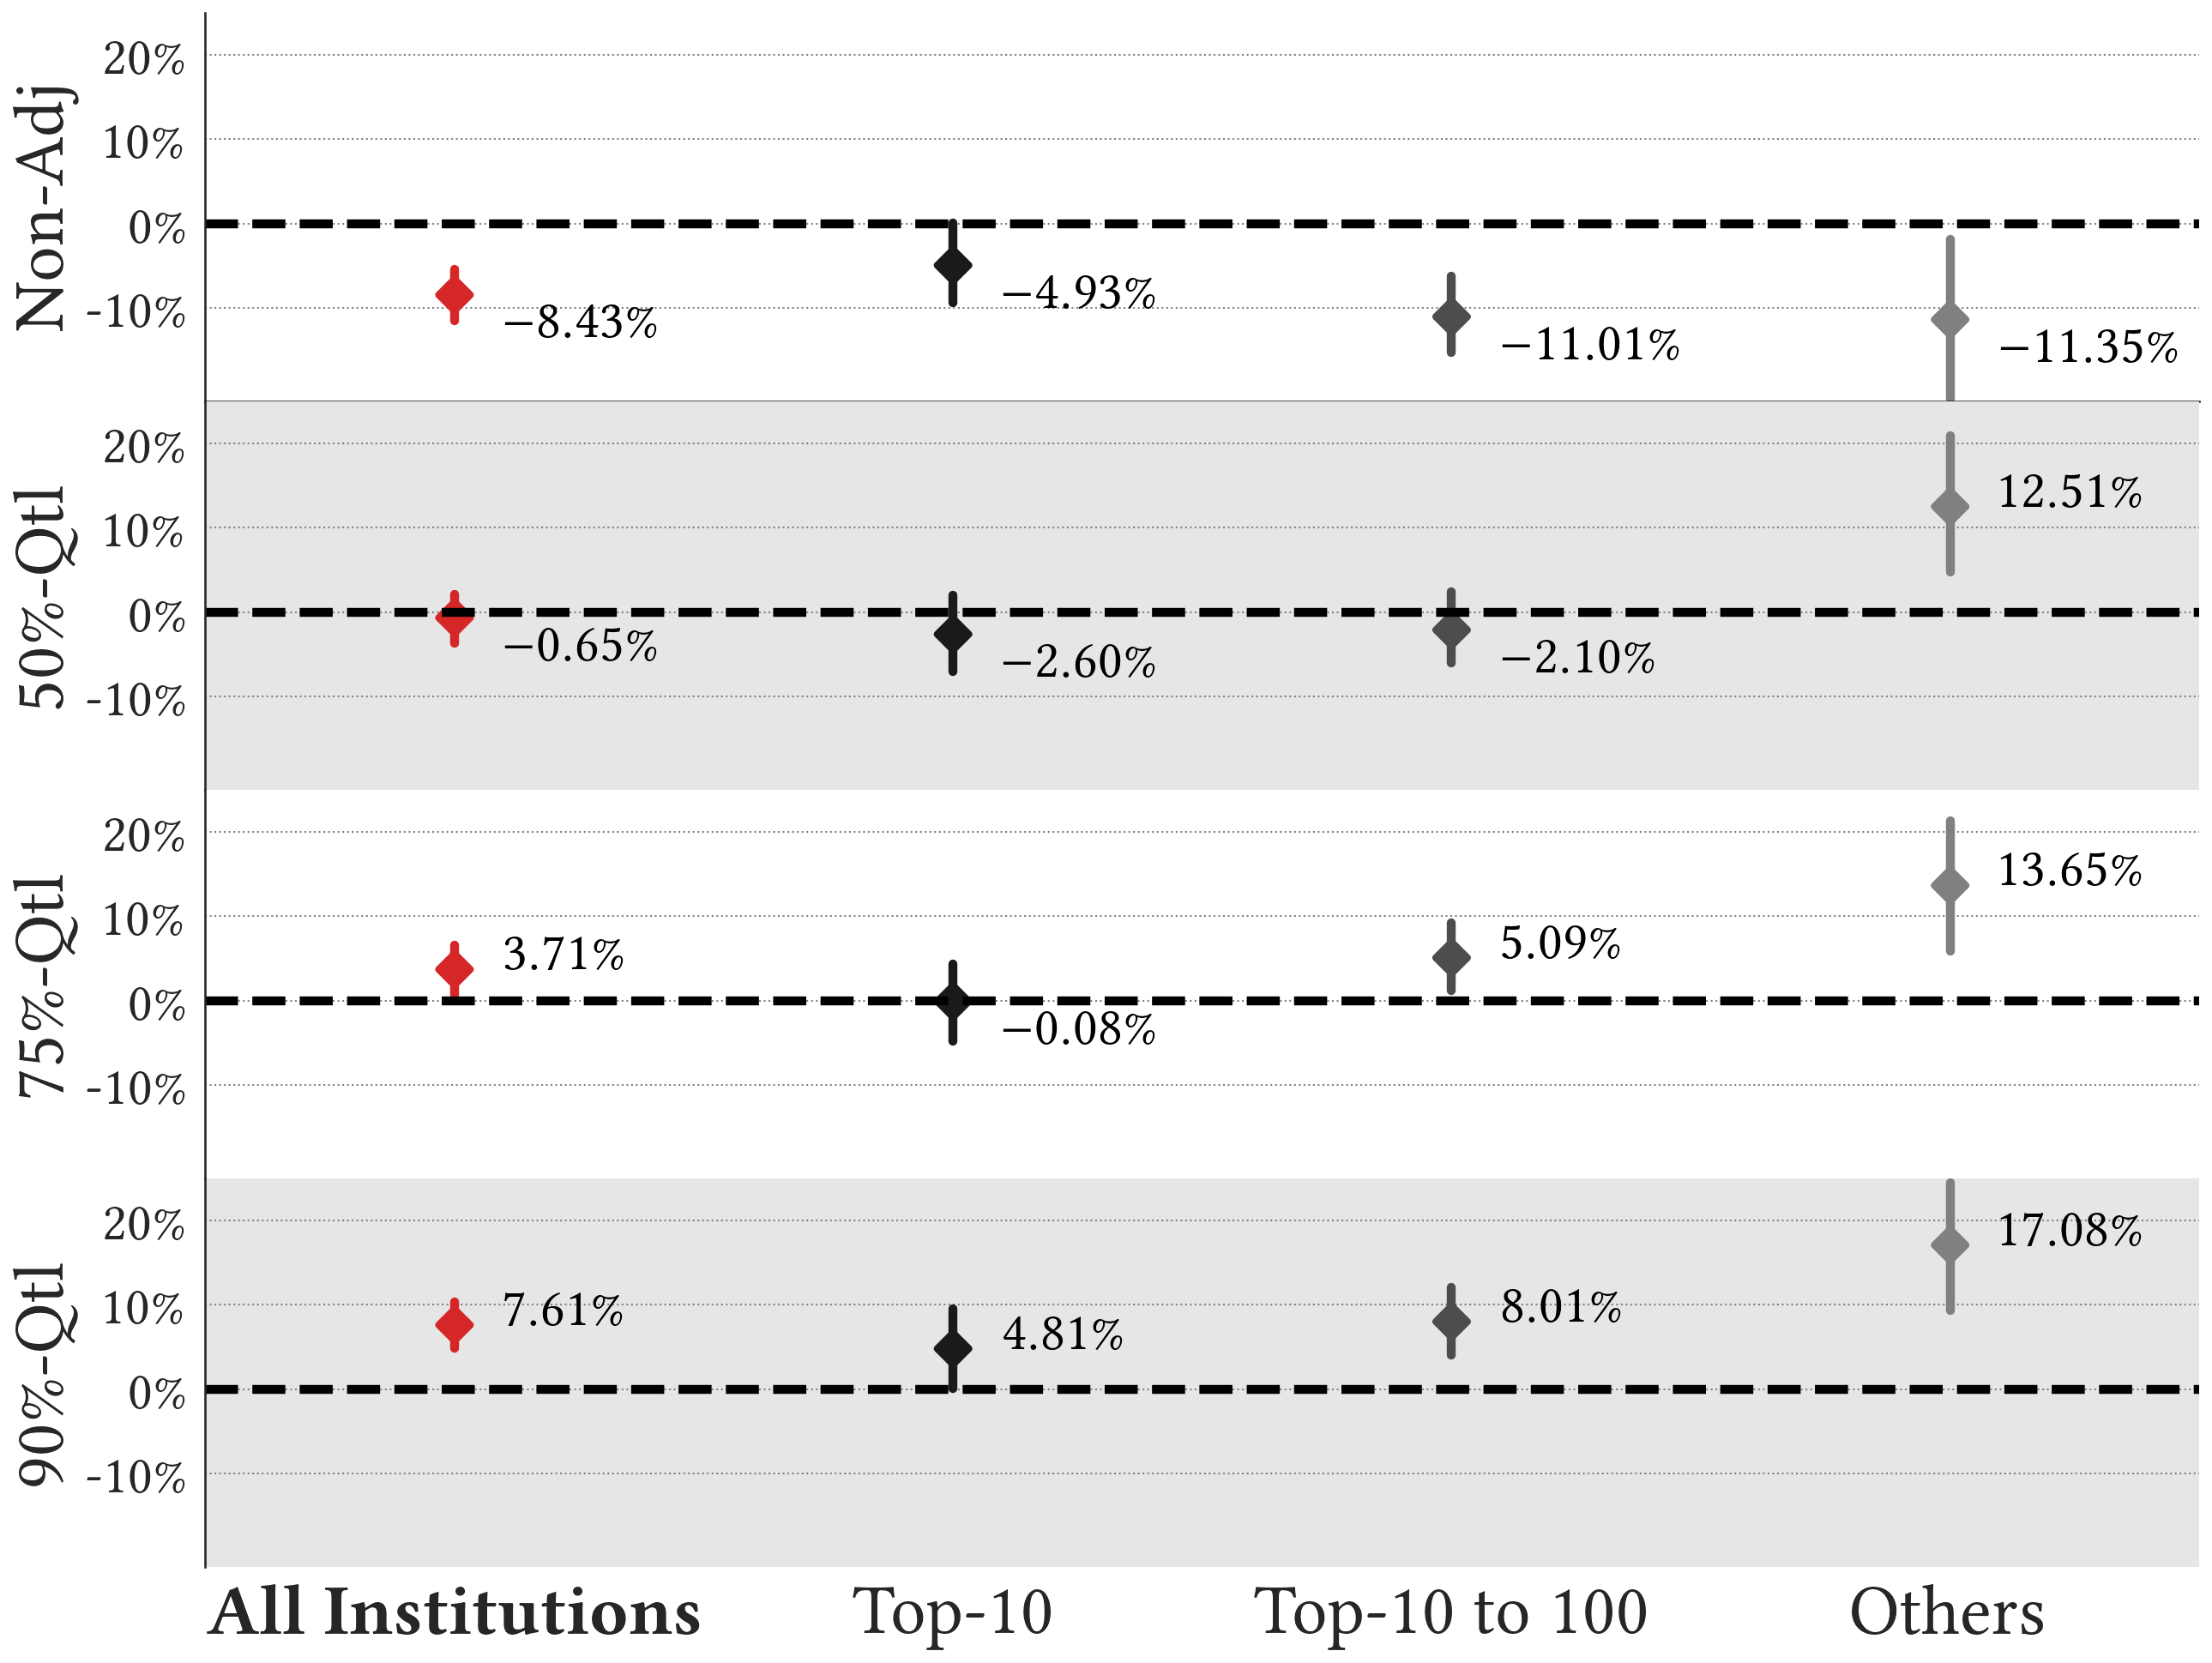

In [511]:
fig, axes = plt.subplots(nrows=4, figsize=(20, 16), dpi=150)
plt.subplots_adjust(hspace=0,wspace=0)
bg_facecolors = ['1','0.9','1','0.9']

palette = {
    'All Institutions':'tab:red', 
        'top-10': '0.1', 
        '10-100': '0.3', 
        'Other Institutions': '0.5',
       'All Authors': 'tab:red', 
        '<100': '0.1', 
        '100-10000': '0.3', 
        '>10000': '0.5'
}

subgrp_lbs = [r'\textbf{All Institutions}', 'Top-10', 'Top-10 to 100', 'Others']
qs = ['0\%','50\%','75\%','90\%']
quantiles = [r'Non-Adj',r'$50\%$-Qtl',r'$75\%$-Qtl', r'$90\%$-Qtl']
grp = 'Min Institution Rank'#, 'Max Author Citation''
lvs = subgrp_smps['level'].unique()
lvs = ['All Institutions', 'top-10', '10-100', 'Other Institutions']
n_lv = len(lvs) 
N = Ns[0]

for i, (q, ax) in enumerate(zip(qs, axes)):

    plt_dt = subgrp_smps.query(f"N=='{N}' and q=='{q}' and grp=='{grp}'")
    g = sns.pointplot(
        data=plt_dt,
        y="DiD", x="level", 
        orient='v',
        markers='D',
        scale=0.7,
        errorbar=("pi", 95), capsize=0, join=False, 
        palette=palette,
        ax=ax
    )
    
    # cosmetic changes
    ax.axhline(0, ls='--', c='0', lw=2, )
    ax.grid(True, color='grey', which='major', axis='y', lw=1, ls=':')
    [ax.spines[k].set_visible(False) for k in ['top','right']]
    if i != 0:
        ax.spines['bottom'].set_visible(False)
    ax.set_facecolor(bg_facecolors[i])
    ax.set_ylabel(quantiles[i], fontsize=40)
    if i != 3:
        ax.set_xlabel(r'', fontsize=30)
        ax.set_xticklabels([])
    else:
        ax.set_xticklabels(subgrp_lbs)
        ax.set_xlabel(r'', fontsize=30)
#     ax.set_xlabel(['One','Two','Three'][i]+'-Year Citation Count',fontsize=30)
    
    
    # add data label
    point_est = subgrp_smps_ci.query(
            f"N=='{N}' and q=='{q}' and grp=='{grp}'"
    ).set_index('level').loc[lvs].r.values
    [ax.text(p+0.1,l-0.05 if l<0 else l, r"$"+f"{100*l:.2f}\%"+r"$", 
             color='0', fontsize=30) 
         for p,l in zip(ax.get_xticks(), point_est)]

    
#     ax.get_legend().remove()
    ax.set_ylim(-0.21,0.25)
    ax.set_yticks( [-0.1,0,0.1,0.2])
    ax.set_yticklabels([rf'{100*a:.0f}\%'for a  in [-0.1,0,0.1,0.2]])

    plt.setp(g.lines,linewidth=5)
    plt.setp(g.lines,linewidth=5)
    ax.tick_params(axis='x', which='major', labelsize=40)
    ax.tick_params(axis='y', which='major', labelsize=30)

plt.savefig('N1_inst_ci_tnr.pdf',bbox_inches='tight')



## Vertical Subgrp (auth)

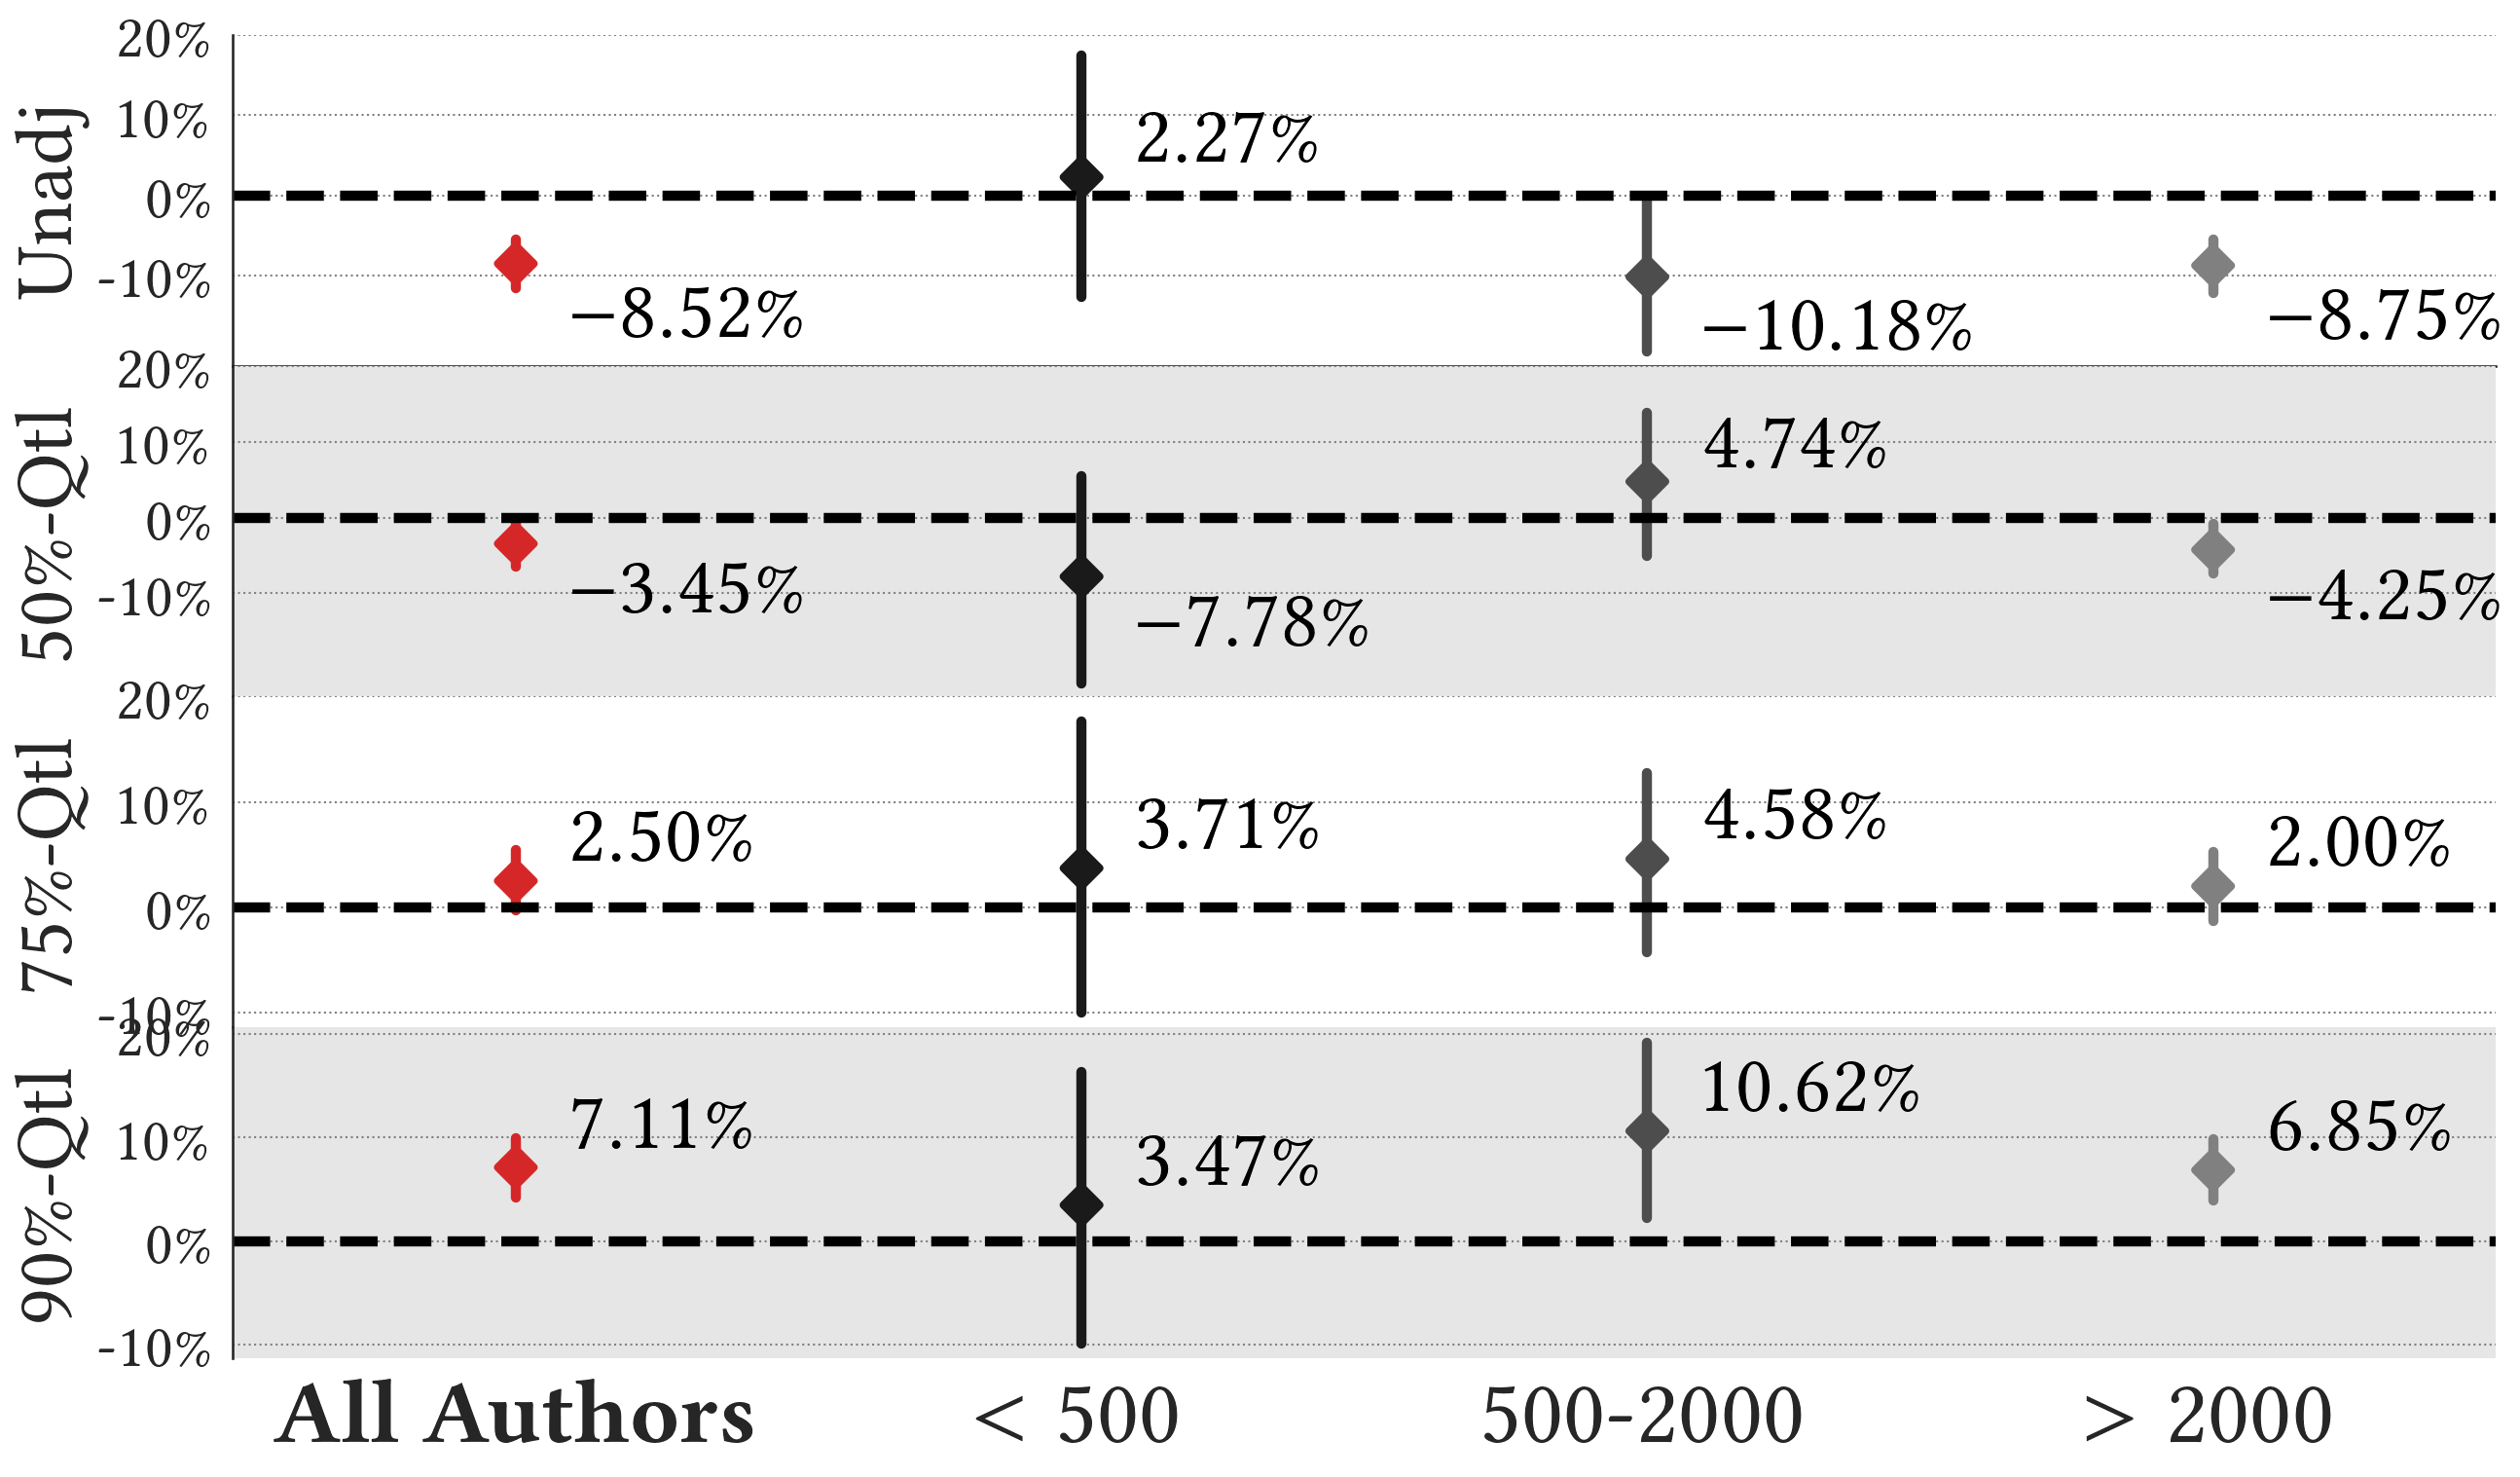

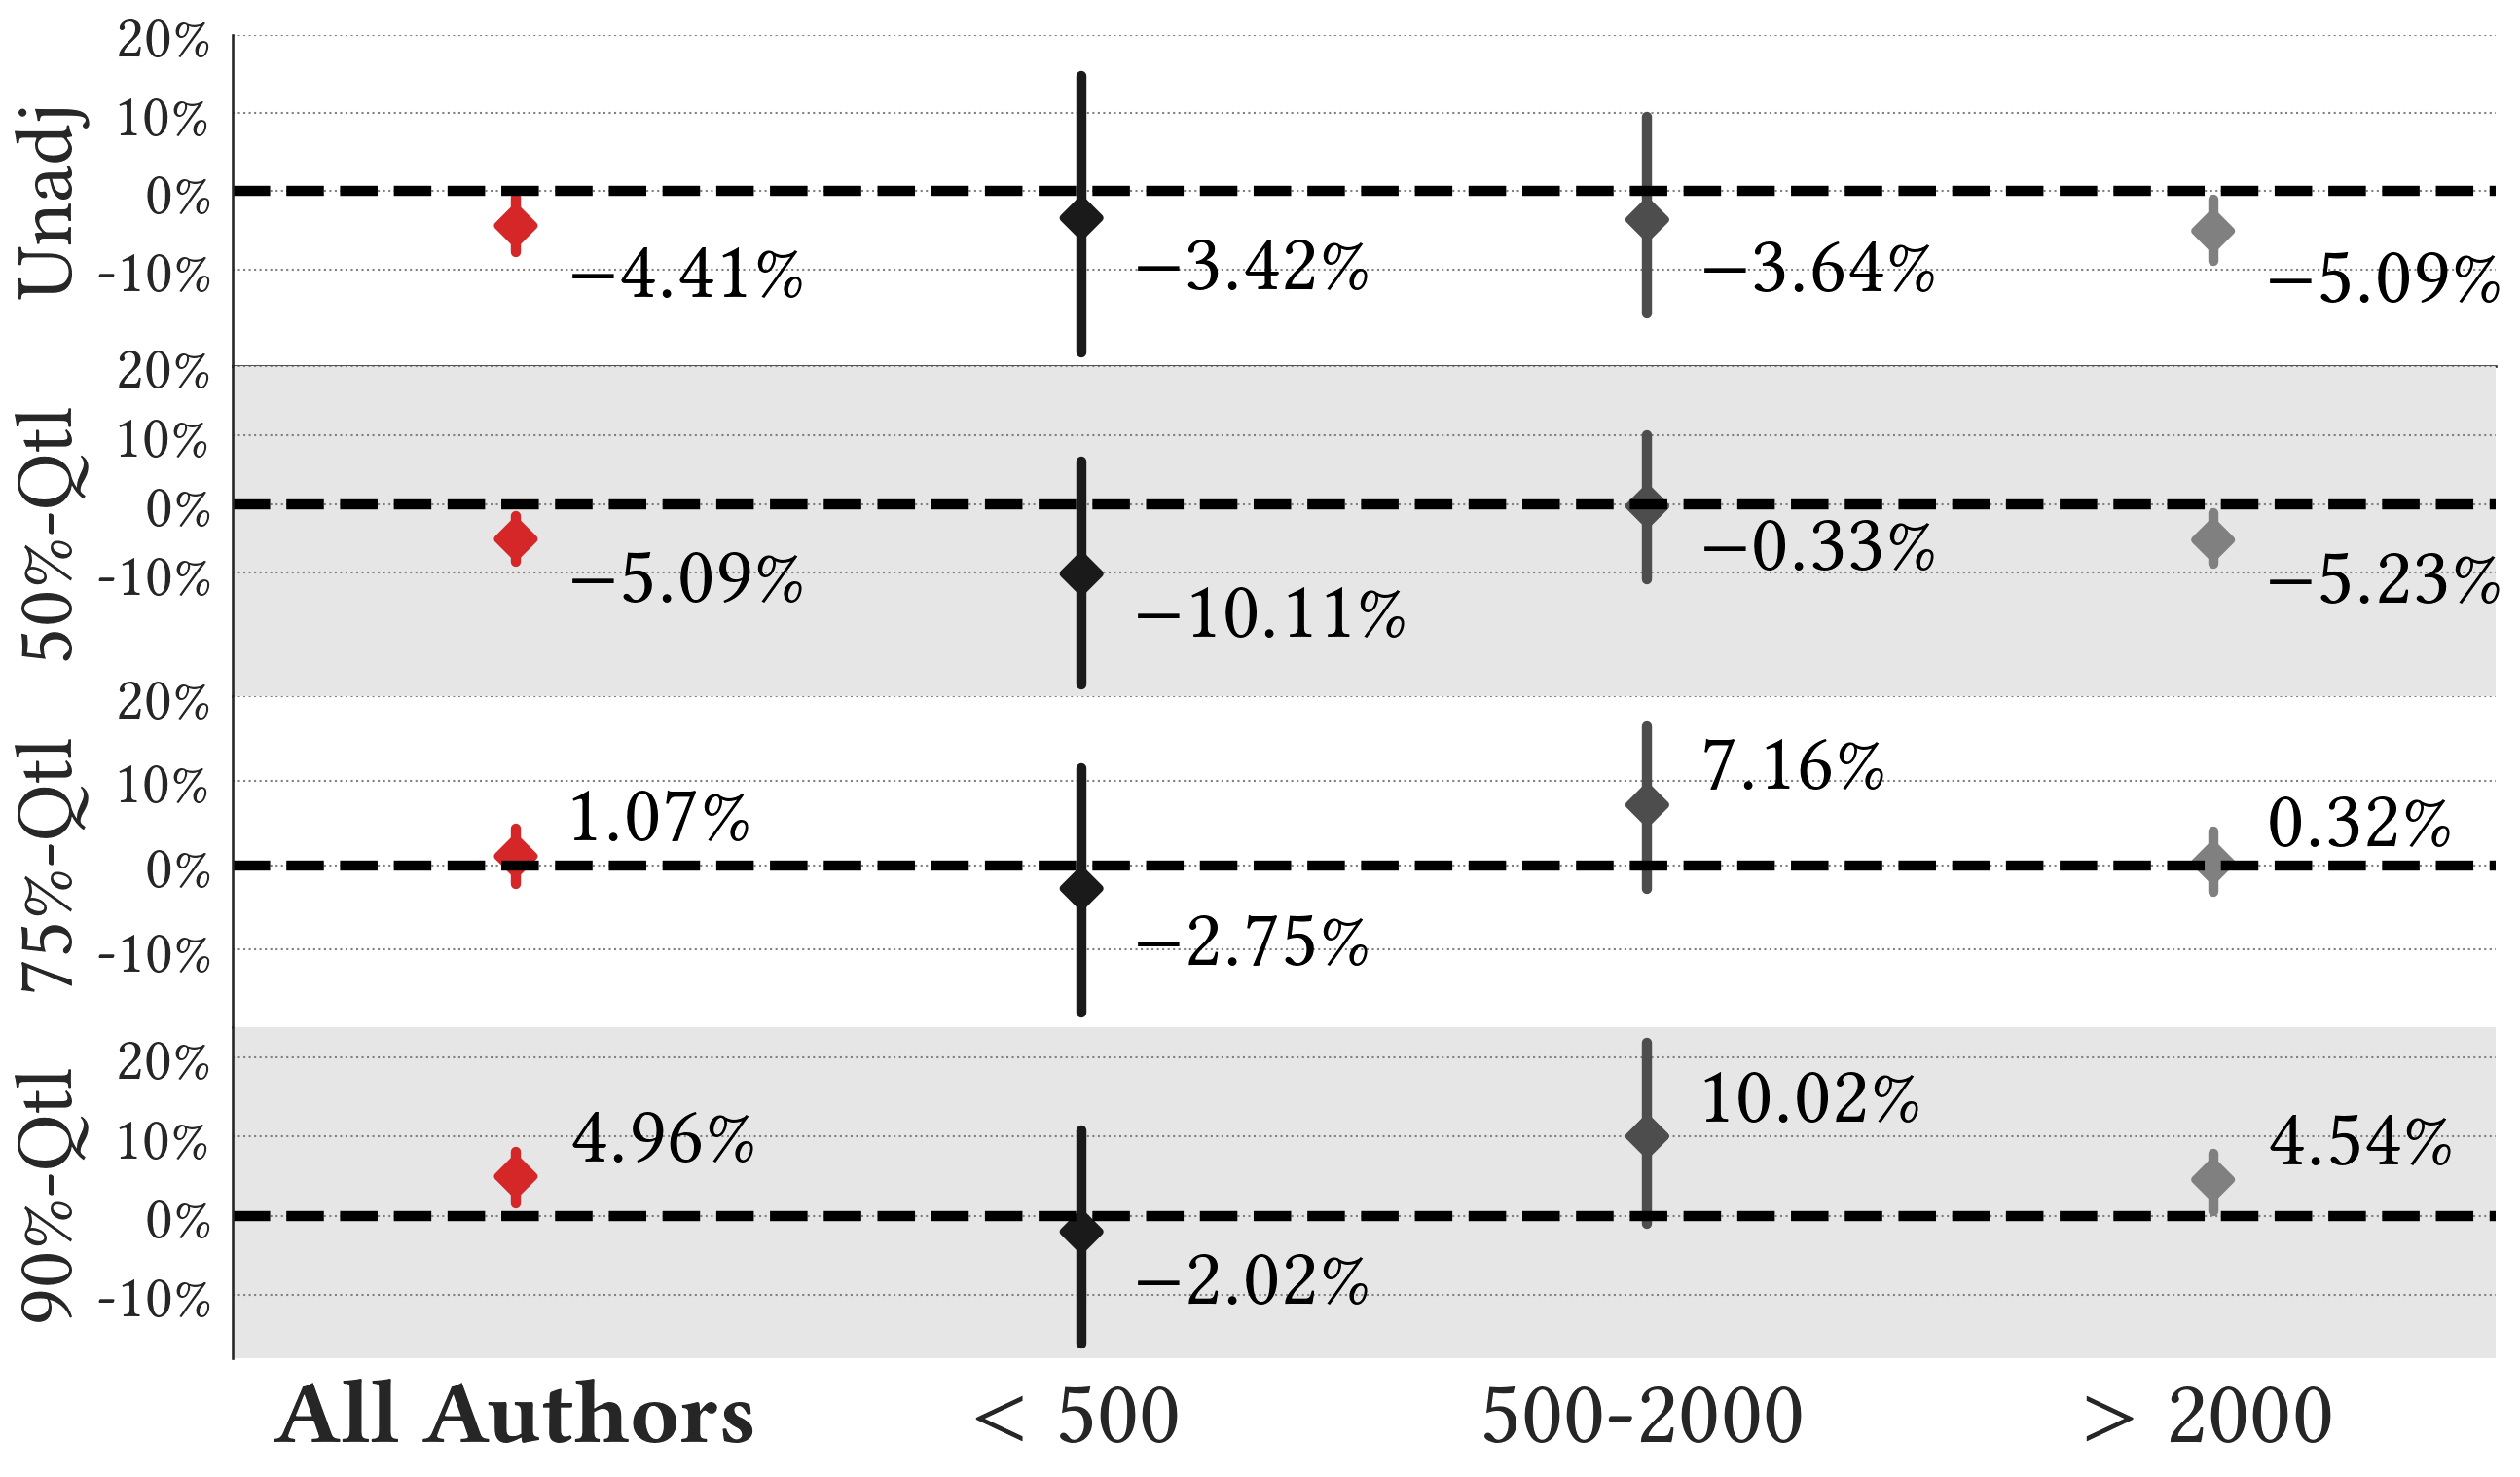

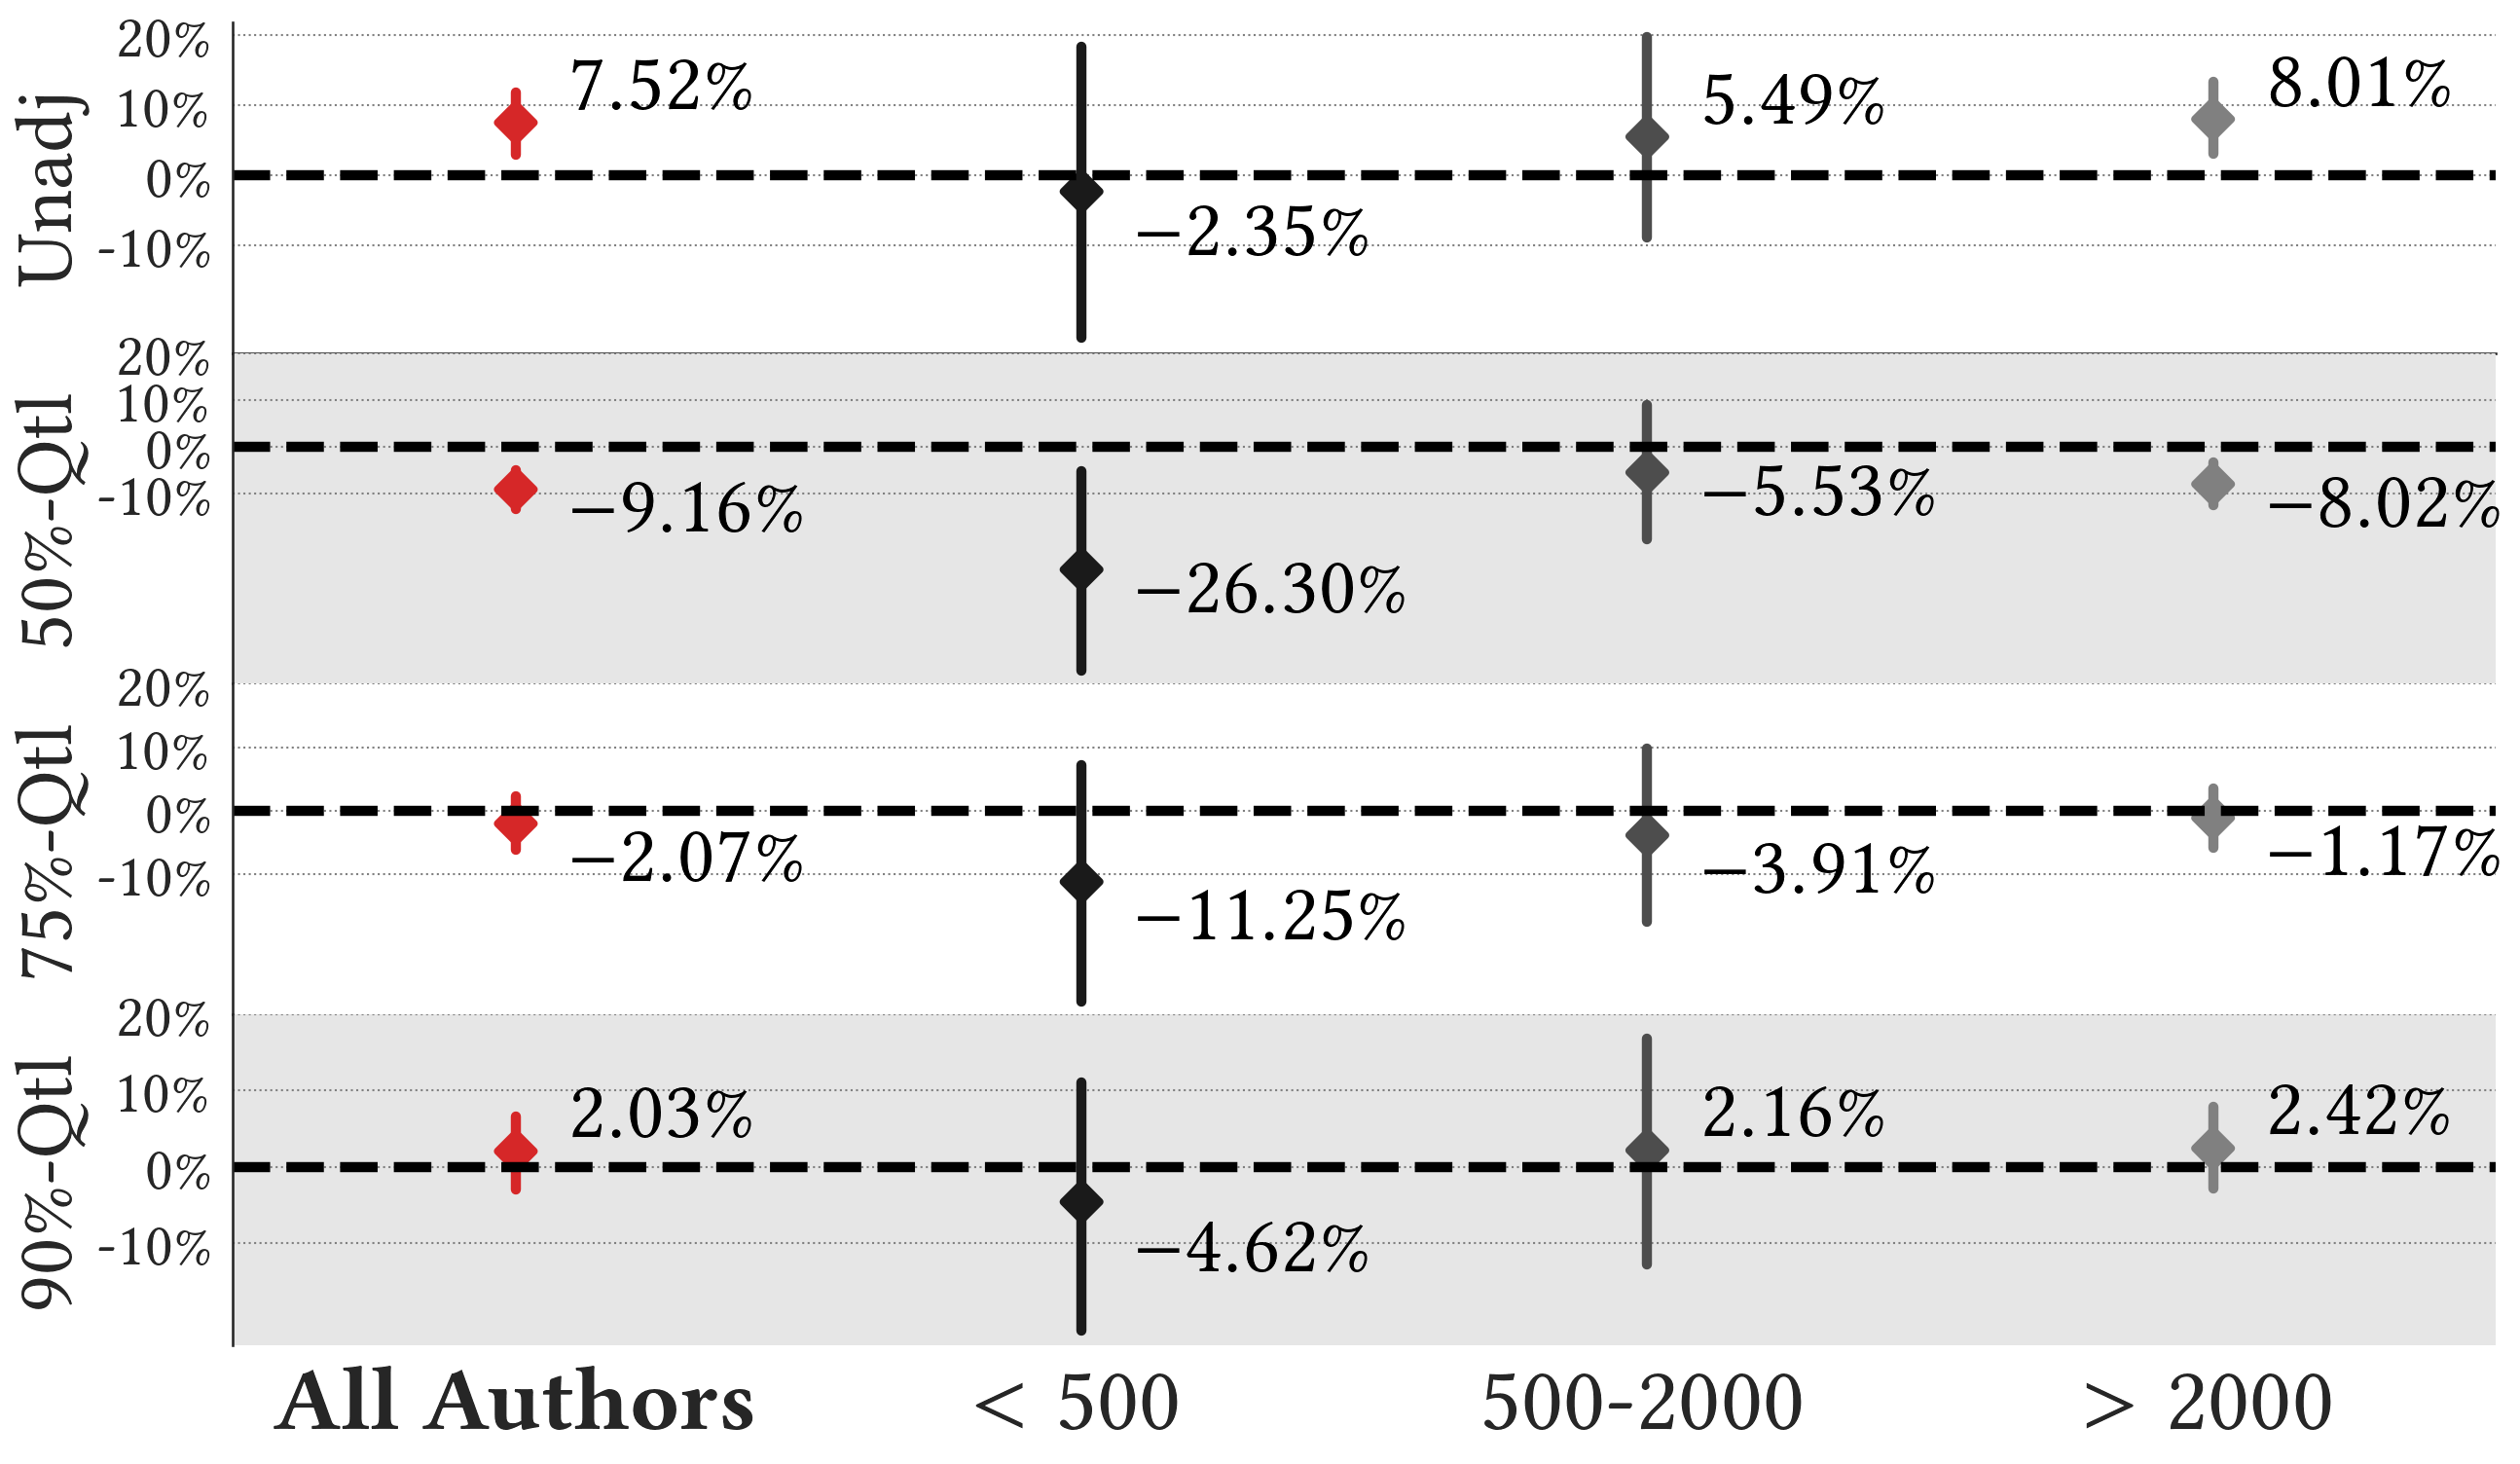

In [605]:
for idx, N in enumerate(Ns):
    fig, axes = plt.subplots(nrows=4, figsize=(20, 12), dpi=150)
    plt.subplots_adjust(hspace=0,wspace=0)
    bg_facecolors = ['1','0.9','1','0.9']

    palette = {
        'All Institutions':'tab:red', 
            'top-10': '0.1', 
            '10-100': '0.3', 
            'Other Institutions': '0.5',
           'All Authors': 'tab:red', 
            '<100': '0.1', 
            '100-10000': '0.3', 
            '>10000': '0.5'
    }

    subgrp_lbs = [r'\textbf{All Authors}', r'$<500$', 
                  '$500$-$2000$', '$>2000$']
    qs = ['0\%','50\%','75\%','90\%']
    quantiles = [r'Unadj',r'$50\%$-Qtl',r'$75\%$-Qtl', r'$90\%$-Qtl']
    grp = 'Max Author Citation'
    lvs = boot_smps['level'].unique()
    lvs = ['All Authors', '<100', '100-10000', '>10000']
    n_lv = len(lvs) 


    for i, (q, ax) in enumerate(zip(qs, axes)):

        plt_dt = boot_smps.query(f"N=='{N}' and q=='{q}' and grp=='{grp}'")
        g = sns.pointplot(
            data=plt_dt,
            y="DiD", x="level", 
            orient='v',
            markers='D',
            scale=0.7,
            errorbar=("pi", 95), capsize=0, join=False, 
            palette=palette,
            ax=ax
        )

        # cosmetic changes
        ax.axhline(0, ls='--', c='0', lw=2, )
        ax.grid(True, color='grey', which='major', axis='y', lw=1, ls=':')
        [ax.spines[k].set_visible(False) for k in ['top','right']]
        if i != 0:
            ax.spines['bottom'].set_visible(False)
        ax.set_facecolor(bg_facecolors[i])
        ax.set_ylabel(quantiles[i], fontsize=40)
        if i != len(axes)-1:
            ax.set_xlabel(r'', fontsize=30)
            ax.set_xticklabels([])
        else:
            ax.set_xticklabels(subgrp_lbs)
            ax.set_xlabel(r'', fontsize=30)

        # add data label
        point_est = boot_smps_ci.query(
                f"N=='{N}' and q=='{q}' and grp=='{grp}'"
        ).set_index('level').loc[lvs].r.values
        [ax.text(p+0.1,l-0.09 if l<0 else l+0.02, r"$"+f"{100*l:.2f}\%"+r"$", 
                 color='0', fontsize=40) 
             for p,l in zip(ax.get_xticks(), point_est)]

        ax.set_yticks( [-0.1,0,0.1,0.2])
        ax.set_yticklabels([rf'{100*a:.0f}\%'for a  in [-0.1,0,0.1,0.2]])

        plt.setp(g.lines,linewidth=5)
        plt.setp(g.lines,linewidth=5)
        ax.tick_params(axis='x', which='major', labelsize=45)
        ax.tick_params(axis='y', which='major', labelsize=30)

    plt.savefig(f'N{idx+1}_auth_ci_tnr_xl.pdf',bbox_inches='tight')

